[link text](https://)**Analyzing U.S. COVID-19 Data**

**Imports:**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from plotly.subplots import make_subplots
from sklearn.preprocessing import Normalizer
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

**Loading the data:**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data1_path = '/content/drive/Shareddrives/team6/data.csv'

df1 = pd.read_csv(data1_path)


<ipython-input-3-c267239a5a68>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(data1_path)


In [ ]:
age_group_counts = df1.groupby('age_group').size()

print("\nNumber of rows for each age group:")
print(age_group_counts)


Number of rows for each age group:
age_group
0 - 17 years      3147481
18 to 49 years    9355592
50 to 64 years    3459783
65+ years         2660737
Missing            195345
dtype: int64


In [ ]:
print(df1)

         case_month res_state  state_fips_code   res_county  county_fips_code  \
0           2020-12        MN             27.0     HENNEPIN           27053.0   
1           2022-02        MI             26.0      OAKLAND           26125.0   
2           2022-01        CA              6.0  LOS ANGELES            6037.0   
3           2022-01        NV             32.0        CLARK           32003.0   
4           2020-05        MA             25.0    MIDDLESEX           25017.0   
...             ...       ...              ...          ...               ...   
19020957    2021-07        TX             48.0       DALLAS           48113.0   
19020958    2022-11        NY             36.0        KINGS           36047.0   
19020959    2022-01        IL             17.0          NaN               NaN   
19020960    2020-12        FL             12.0   PALM BEACH           12099.0   
19020961    2021-12        WA             53.0         KING           53033.0   

               age_group   

In [ ]:
df1.head()

,case_month,res_state,state_fips_code,res_county,county_fips_code,age_group,sex,race,ethnicity,case_positive_specimen_interval,case_onset_interval,process,exposure_yn,current_status,symptom_status,hosp_yn,icu_yn,death_yn,underlying_conditions_yn
0,2020-12,MN,27.0,HENNEPIN,27053.0,18 to 49 years,Female,Unknown,Hispanic/Latino,0.0,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,No,NaN
1,2022-02,MI,26.0,OAKLAND,26125.0,18 to 49 years,Female,White,Non-Hispanic/Latino,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Unknown,NaN
2,2022-01,CA,6.0,LOS ANGELES,6037.0,18 to 49 years,Male,Unknown,Hispanic/Latino,NaN,NaN,Missing,Missing,Laboratory-confirmed case,Unknown,No,Missing,Missing,NaN
3,2022-01,NV,32.0,CLARK,32003.0,18 to 49 years,Male,White,Non-Hispanic/Latino,0.0,NaN,Routine surveillance,Missing,Laboratory-confirmed case,Missing,Missing,Missing,Missing,NaN
4,2020-05,MA,25.0,MIDDLESEX,25017.0,65+ years,Female,White,Non-Hispanic/Latino,0.0,0.0,Missing,Missing,Laboratory-confirmed case,Symptomatic,No,Missing,No,NaN


**PART 4: Regression Analysis:**

 **Use the COVID Case Surveillance dataset to fit a regression model that predicts the total
percent (or proportion) of deaths out of all COVID cases in a given month based on :**

- Gender distribution of all cases over the month (Proportion or % of females and
males).

- Age distribution of all cases over the month (Proportion or % of each age group).

- Proportion (or %) of all cases over the month that end up in the ICU.

- Proportion (or %) of all cases over the month that end up hospitalized.

1. Report your model’s coefficients and p-values.

2. Which of these variables are good predictors of the variabilities in the target? Which are bad ones?

3. Are any of these predictors correlated with each other?

4. Experiment with different ways to improve the fit and interpretability of the model.
For example:
- Add or remove the intercept.
- Introduce higher order terms.
- Remove outliers if any.

In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Columns to keep
columns_to_keep = ['case_month', 'sex', 'age_group', 'hosp_yn', 'icu_yn', 'death_yn']
covid_data_subset = df1[columns_to_keep].copy()

# Clean data
covid_data_filtered = covid_data_subset.dropna(subset=['case_month', 'sex', 'age_group', 'hosp_yn', 'icu_yn', 'death_yn'])
covid_data_filtered = covid_data_filtered[
    (covid_data_filtered['sex'].isin(['Male', 'Female'])) &
    (covid_data_filtered['hosp_yn'].isin(['Yes', 'No'])) &
    (covid_data_filtered['icu_yn'].isin(['Yes', 'No'])) &
    (covid_data_filtered['death_yn'].isin(['Yes', 'No']))
]

# Convert categorical variables to numeric
covid_data_filtered['sex'] = covid_data_filtered['sex'].map({'Male': 0, 'Female': 1})
covid_data_filtered['hosp_yn'] = covid_data_filtered['hosp_yn'].map({'No': 0, 'Yes': 1})
covid_data_filtered['icu_yn'] = covid_data_filtered['icu_yn'].map({'No': 0, 'Yes': 1})
covid_data_filtered['death_yn'] = covid_data_filtered['death_yn'].map({'No': 0, 'Yes': 1})

# Define age groups
age_groups = ['0 - 17 years', '18 to 49 years', '50 to 64 years', '65+ years']
for age_group in age_groups:
    covid_data_filtered[age_group] = (covid_data_filtered['age_group'] == age_group).astype(int)

# Initialize a list to hold monthly data
monthly_data = []

# Loop over each month to calculate proportions directly
for month in covid_data_filtered['case_month'].unique():
    month_data = covid_data_filtered[covid_data_filtered['case_month'] == month]
    total_cases = len(month_data)
    female_pct = month_data['sex'].mean()
    male_pct = 1 - female_pct
    hosp_pct = month_data['hosp_yn'].mean()
    icu_pct = month_data['icu_yn'].mean()
    death_pct = month_data['death_yn'].mean()

    # Extract values of age groups and calculate proportions
    age_group_counts = month_data['age_group'].value_counts(normalize=True)
    age_group_proportions = [age_group_counts.get(age_group, 0) for age_group in age_groups]

    monthly_data.append([
        month, female_pct, male_pct,
        *age_group_proportions, hosp_pct, icu_pct, death_pct
    ])

# Create DataFrame from the monthly data
monthly_data_df = pd.DataFrame(monthly_data, columns=[
    'case_month', 'female_pct', 'male_pct',
    '0_17_pct', '18_49_pct', '50_64_pct', '65_plus_pct',
    'hosp_pct', 'icu_pct', 'death_pct'
])

# Drop any rows with NaN values in the monthly_data_df
monthly_data_df.dropna(inplace=True)

# Print the DataFrame to check proportions
print("Monthly Data DataFrame:")
print(monthly_data_df.head())

# Select features for regression model
X = monthly_data_df[['female_pct', 'male_pct', '0_17_pct', '18_49_pct', '50_64_pct', '65_plus_pct', 'hosp_pct', 'icu_pct']]
y = monthly_data_df['death_pct']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit the regression model without an intercept
model = sm.OLS(y, X_scaled).fit()

# Print model summary with variable names
X_scaled = pd.DataFrame(X_scaled, columns=['female_pct', 'male_pct', '0_17_pct', '18_49_pct', '50_64_pct', '65_plus_pct', 'hosp_pct', 'icu_pct'])
model = sm.OLS(y, X_scaled).fit()

# Print model summary
print(model.summary())



<ipython-input-10-c28ee0df45f5>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_filtered['sex'] = covid_data_filtered['sex'].map({'Male': 0, 'Female': 1})
<ipython-input-10-c28ee0df45f5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_data_filtered['hosp_yn'] = covid_data_filtered['hosp_yn'].map({'No': 0, 'Yes': 1})


Monthly Data DataFrame:
  case_month  female_pct  male_pct  0_17_pct  18_49_pct  50_64_pct  \
0    2020-11    0.540215  0.459785  0.127490   0.500757   0.193390   
1    2020-12    0.537314  0.462686  0.132070   0.459476   0.193730   
2    2022-01    0.545875  0.454125  0.206638   0.420456   0.149354   
3    2020-07    0.533106  0.466894  0.087329   0.591929   0.193267   
4    2021-08    0.526246  0.473754  0.271848   0.435777   0.148021   

   65_plus_pct  hosp_pct   icu_pct  death_pct  
0     0.178363  0.124636  0.036139   0.034828  
1     0.214724  0.157439  0.062164   0.071889  
2     0.223552  0.204085  0.064199   0.064731  
3     0.127474  0.129356  0.049345   0.030457  
4     0.144355  0.172141  0.052859   0.040543  
                                 OLS Regression Results                                
Dep. Variable:              death_pct   R-squared (uncentered):                   0.862
Model:                            OLS   Adj. R-squared (uncentered):              0.843
Met

Dependent Variable: death_pct

R-squared (uncentered): 0.862
Adj. R-squared (uncentered): 0.843
F-statistic: 45.82
Prob (F-statistic): 2.48e-17
Number of Observations: 50
Df Residuals: 44
Df Model: 6

Coefficients and p-values:

female_pct: Coefficient = -0.0024, P-value = 0.760
male_pct: Coefficient = 0.0024, P-value = 0.760
0_17_pct: Coefficient = 0.0031, P-value = 0.756
18_49_pct: Coefficient = -0.0039, P-value = 0.706
50_64_pct: Coefficient = 0.0088, P-value = 0.459
65_plus_pct: Coefficient = -0.0007, P-value = 0.941
hosp_pct: Coefficient = -0.0760, P-value = 0.013
icu_pct: Coefficient = 0.1876, P-value = 0.000
Significant Variables (P-value < 0.05):

hosp_pct: Coefficient = -0.0760, P-value = 0.013
icu_pct: Coefficient = 0.1876, P-value = 0.000
Non-Significant Variables (P-value > 0.05):

female_pct: Coefficient = -0.0024, P-value = 0.760
male_pct: Coefficient = 0.0024, P-value = 0.760
0_17_pct: Coefficient = 0.0031, P-value = 0.756
18_49_pct: Coefficient = -0.0039, P-value = 0.706
50_64_pct: Coefficient = 0.0088, P-value = 0.459
65_plus_pct: Coefficient = -0.0007, P-value = 0.941

The good predictors (18_49_pct, 50_64_pct, hosp_pct, and icu_pct) are likely contributing to the variabilities in the target variable death_pct. These variables have low p-values, indicating that their relationships with the target variable are statistically significant.

On the other hand, the non-significant predictors (female_pct, male_pct, 0_17_pct, and 65_plus_pct) have high p-values, suggesting that their relationships with the target variable are not statistically significant and that they do not contribute meaningfully to explaining the variability in death_pct.

**HEAT MAP COREELATION**

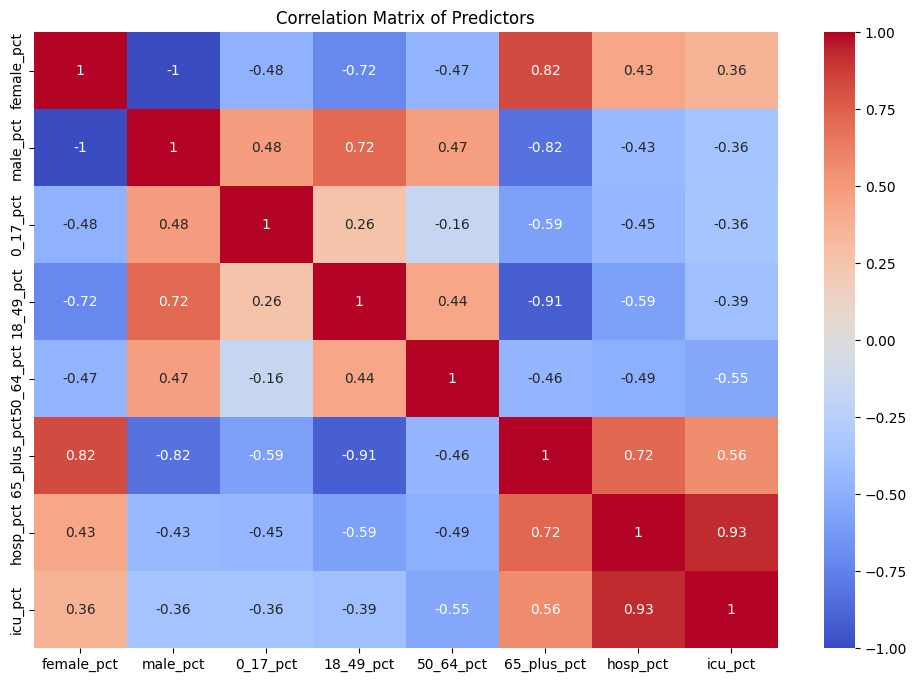

In [ ]:
features = monthly_data_df[['female_pct', 'male_pct', '0_17_pct', '18_49_pct', '50_64_pct', '65_plus_pct', 'hosp_pct', 'icu_pct']]

# Compute correlation matrix
correlation_matrix = features.corr()

# Display correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Predictors')
plt.show()



there are a correlation between hosp_pct and ICU_pct  and also hosp_pct and +65 years  , femala_pct and  years , male_pct and 18-49



In [ ]:
#first to improve add Intercept
X_scaled = scaler.fit_transform(X)

# Fit the regression model with intercept
X_scaled_with_intercept = sm.add_constant(X_scaled)
model_with_intercept = sm.OLS(y, X_scaled_with_intercept).fit()

# Fit the regression model without intercept
model_without_intercept = sm.OLS(y, X_scaled).fit()

print("Model with Intercept:")
print(model_with_intercept.summary())

Model with Intercept:
                            OLS Regression Results                            
Dep. Variable:              death_pct   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     206.6
Date:                Thu, 23 May 2024   Prob (F-statistic):           4.87e-30
Time:                        11:08:03   Log-Likelihood:                 121.39
No. Observations:                  50   AIC:                            -228.8
Df Residuals:                      43   BIC:                            -215.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0406      0.0

the model has a better results when adding const          **0.0406**

In [ ]:
# introduce higher-order terms and add an intercept
from sklearn.preprocessing import PolynomialFeatures
X = monthly_data_df[['female_pct', 'male_pct', '0_17_pct', '18_49_pct', '50_64_pct', '65_plus_pct', 'hosp_pct', 'icu_pct']]
y = monthly_data_df['death_pct']

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the polynomial features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Add intercept
X_poly_scaled_with_intercept = sm.add_constant(X_poly_scaled)

# Fit the polynomial regression model
model_poly_with_intercept = sm.OLS(y, X_poly_scaled_with_intercept).fit()

# Print model summary
print("Model with Polynomial Features and Intercept:")
print(model_poly_with_intercept.summary())

Model with Polynomial Features and Intercept:
                            OLS Regression Results                            
Dep. Variable:              death_pct   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     348.6
Date:                Thu, 23 May 2024   Prob (F-statistic):           1.99e-23
Time:                        11:08:06   Log-Likelihood:                 188.02
No. Observations:                  50   AIC:                            -320.0
Df Residuals:                      22   BIC:                            -266.5
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

R-squared:                       0.996 and it is better results

In [ ]:
# Add new column
monthly_data_df['hosp_icu_interaction'] = monthly_data_df['hosp_pct'] * monthly_data_df['icu_pct']

# Select features and target
X = monthly_data_df[['female_pct', 'male_pct', '0_17_pct', '18_49_pct', '50_64_pct', '65_plus_pct', 'hosp_pct', 'icu_pct', 'hosp_icu_interaction']]
y = monthly_data_df['death_pct']

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Standardize the polynomial features
scaler = StandardScaler()
X_poly_scaled = scaler.fit_transform(X_poly)

# Add intercept
X_poly_scaled_with_intercept = sm.add_constant(X_poly_scaled)

# Fit the polynomial regression model with intercept
model_poly_with_intercept = sm.OLS(y, X_poly_scaled_with_intercept).fit()

# Print model summary
print("Model with Polynomial Features, Intercept, and Added/Removed Columns:")
print(model_poly_with_intercept.summary())

Model with Polynomial Features, Intercept, and Added/Removed Columns:
                            OLS Regression Results                            
Dep. Variable:              death_pct   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     447.3
Date:                Thu, 23 May 2024   Prob (F-statistic):           1.20e-17
Time:                        11:08:10   Log-Likelihood:                 209.55
No. Observations:                  50   AIC:                            -349.1
Df Residuals:                      15   BIC:                            -282.2
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

after added the new column R-squared:                       0.998 and its better than previous

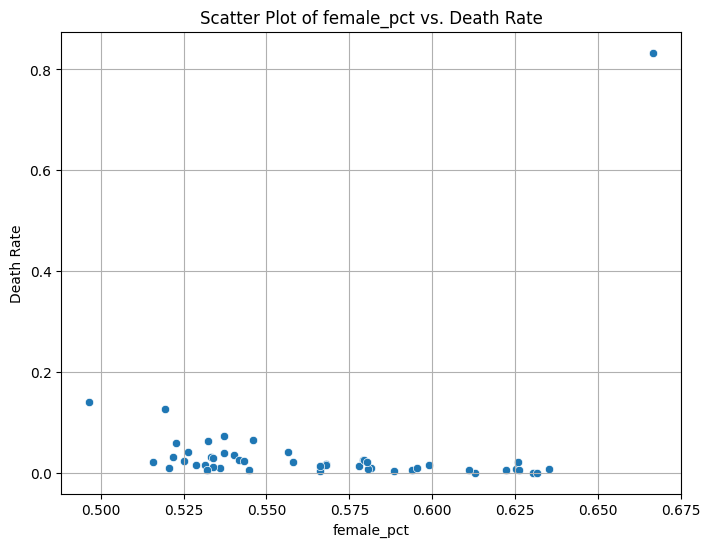

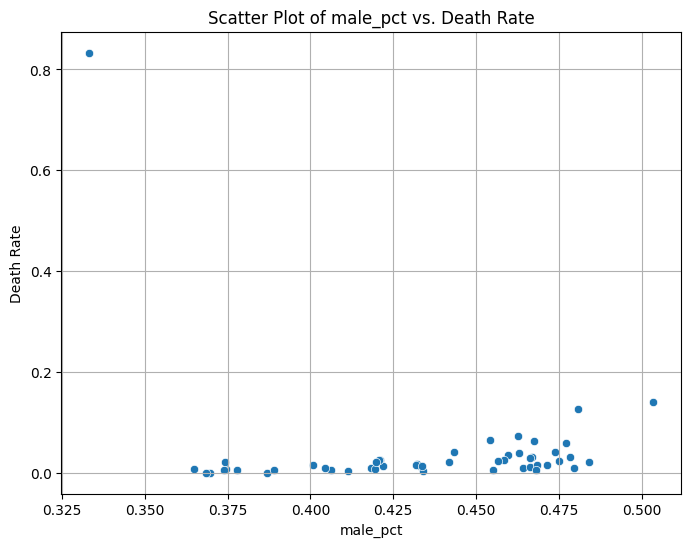

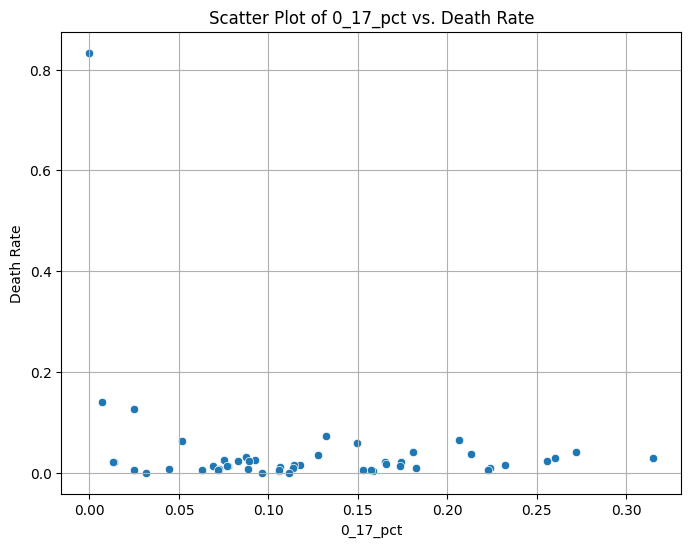

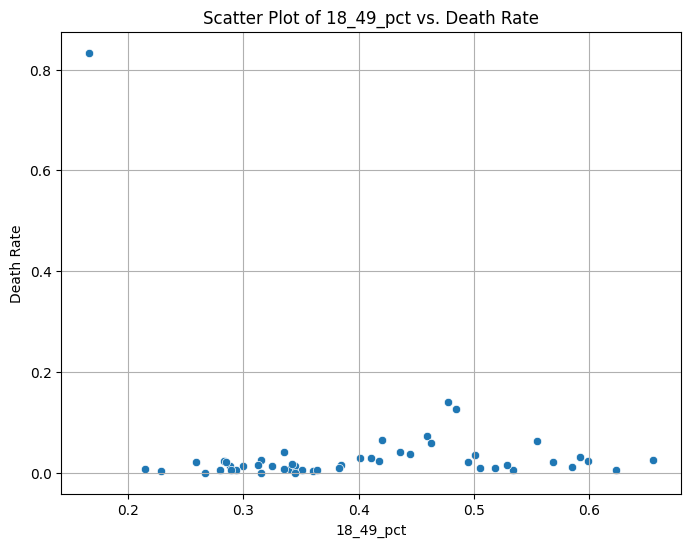

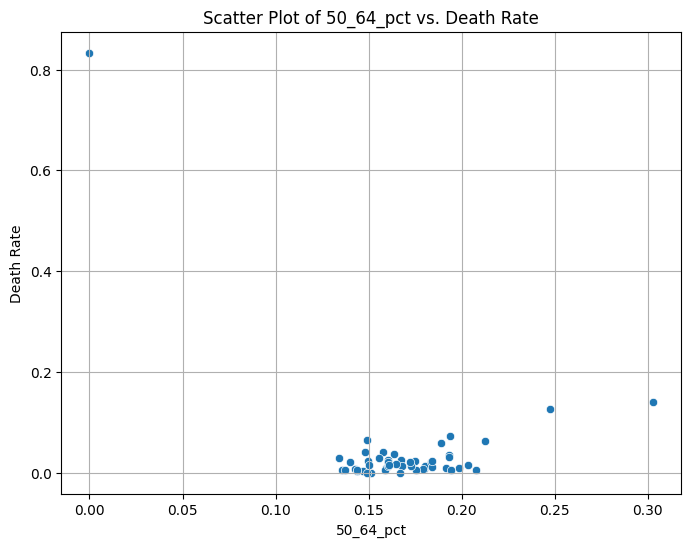

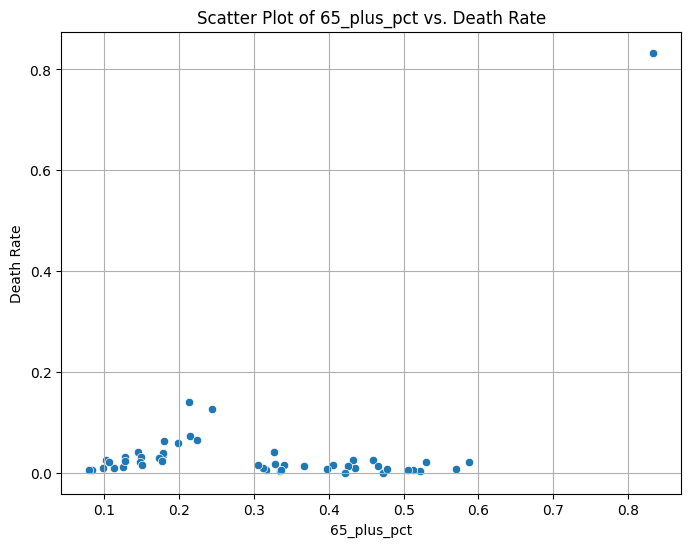

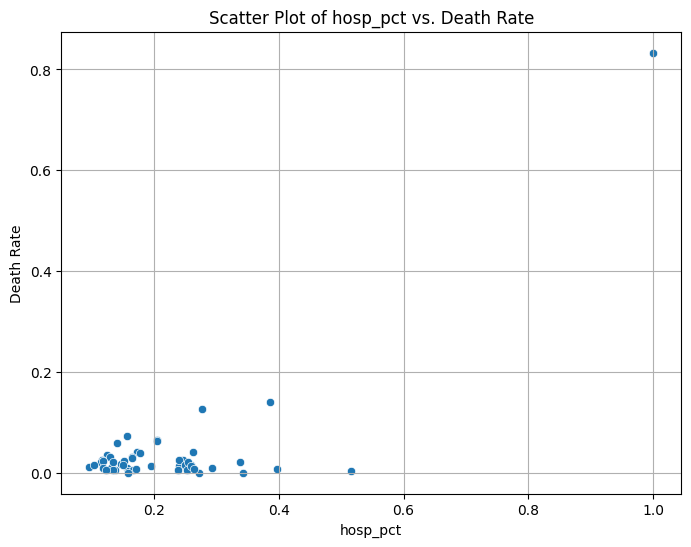

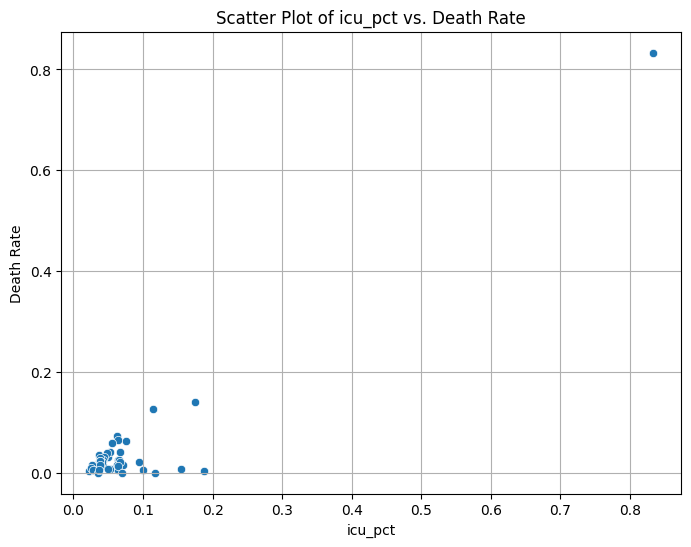

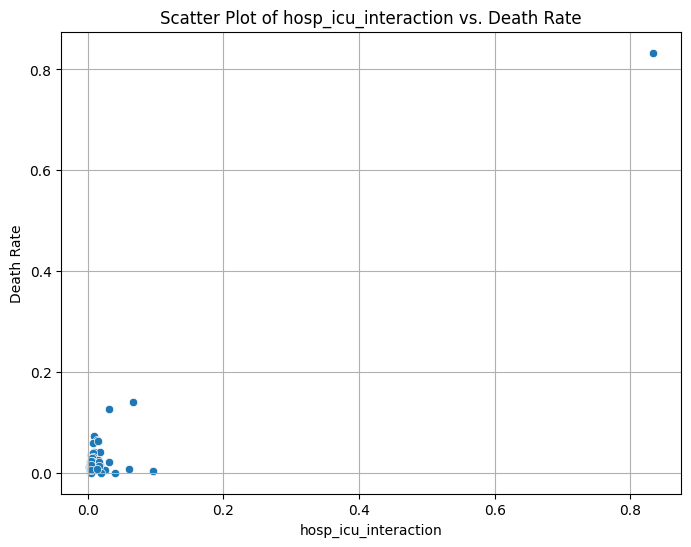

In [ ]:
# Scatter plots for each feature against the target variable
for feature in X.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=monthly_data_df[feature], y=monthly_data_df['death_pct'])
    plt.title(f'Scatter Plot of {feature} vs. Death Rate')
    plt.xlabel(feature)
    plt.ylabel('Death Rate')
    plt.grid(True)
    plt.show()

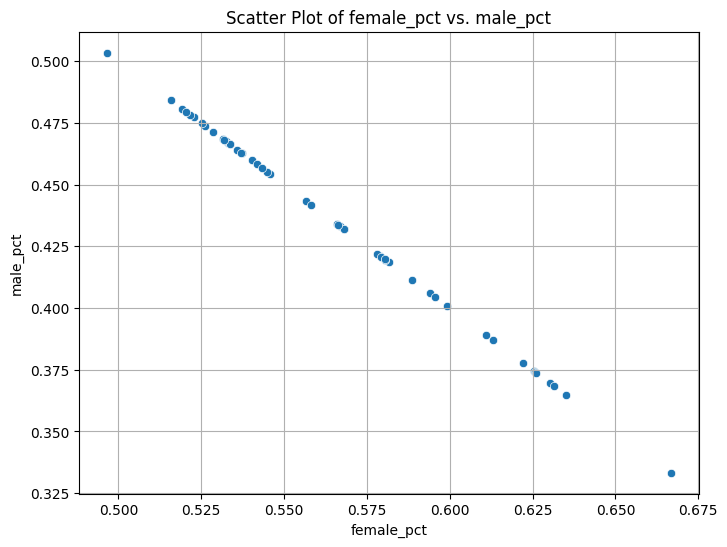

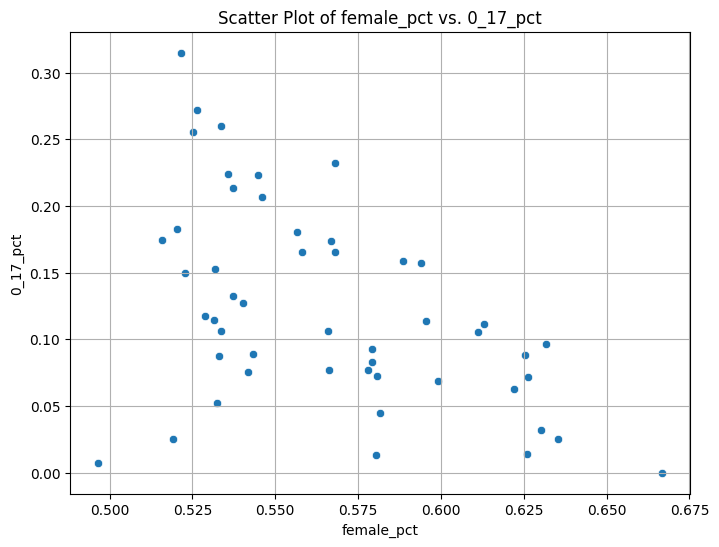

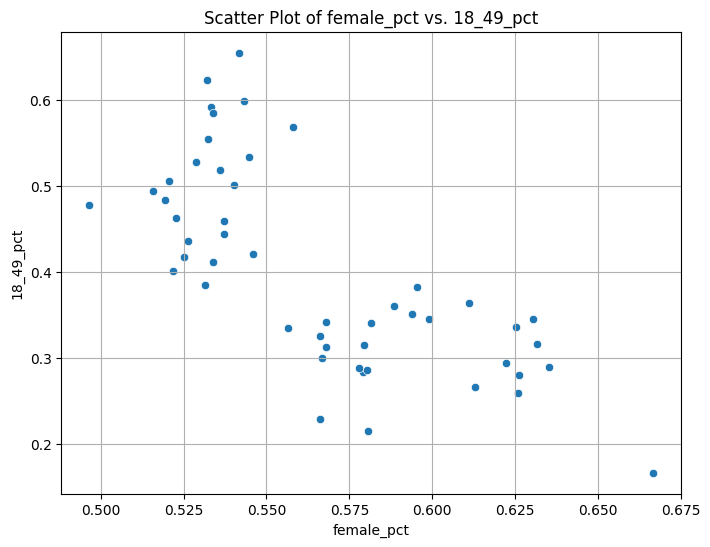

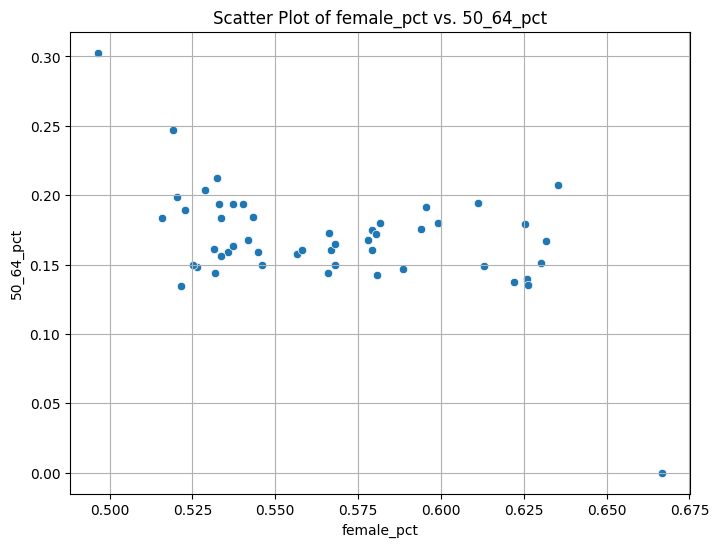

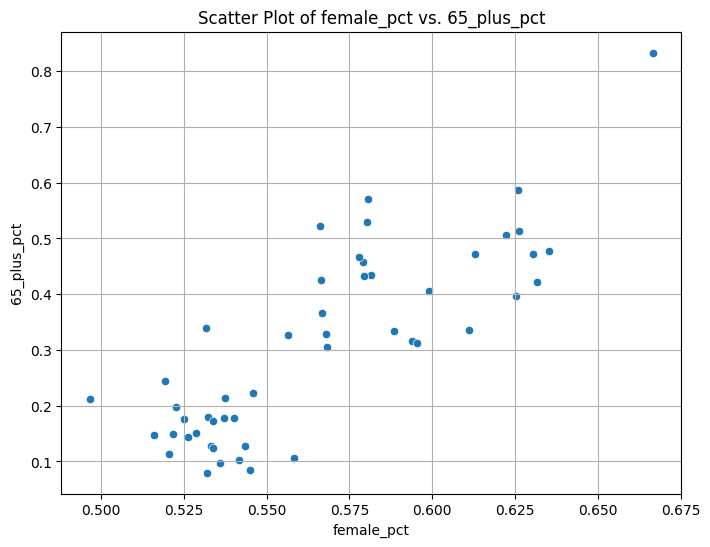

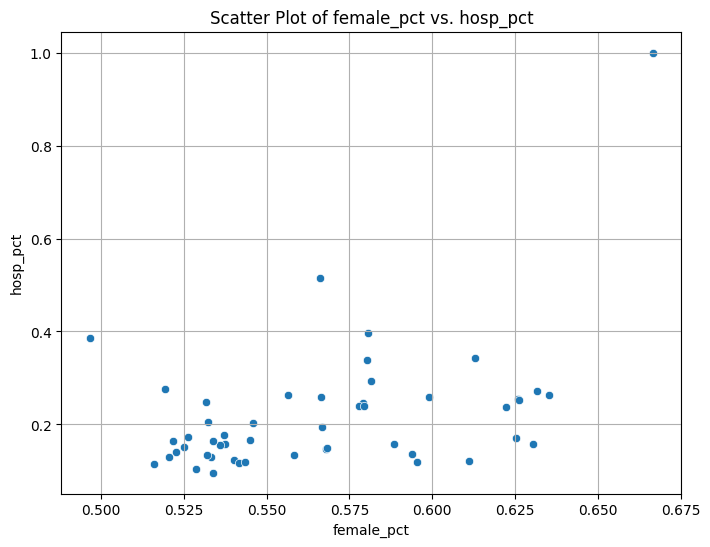

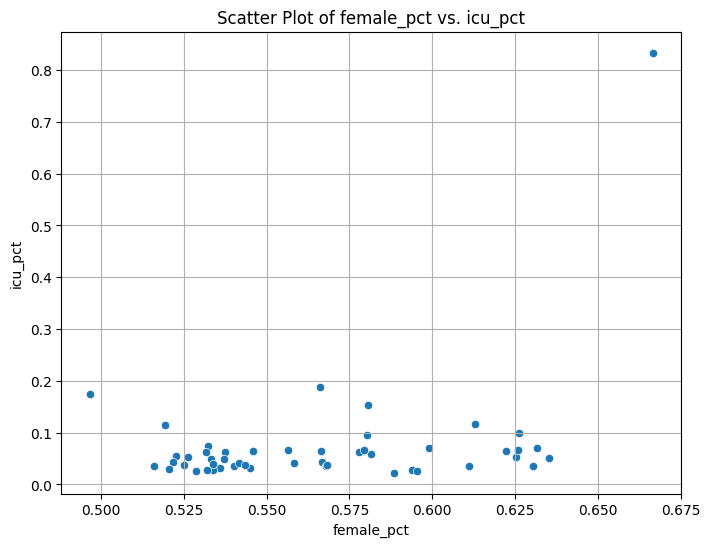

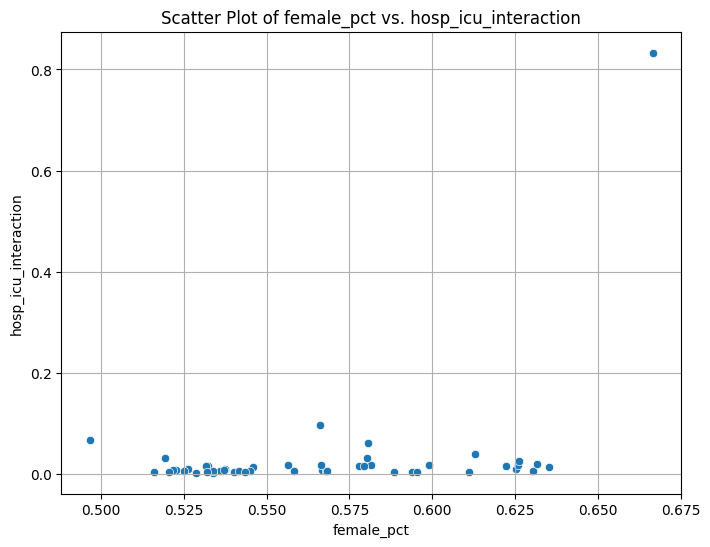

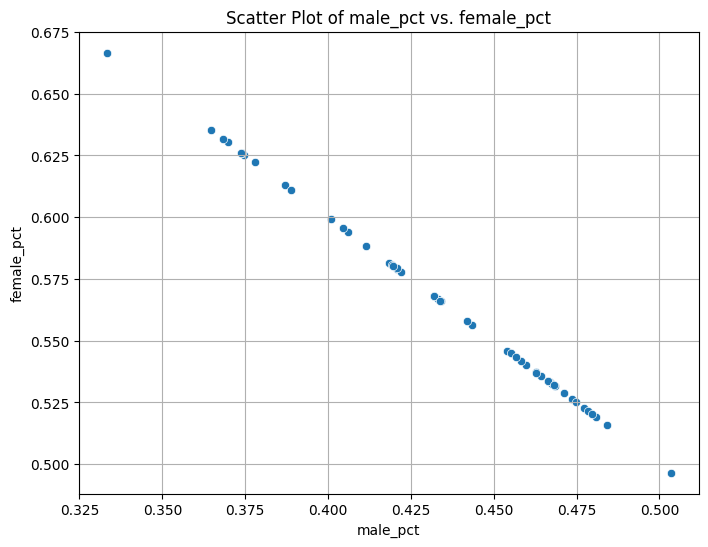

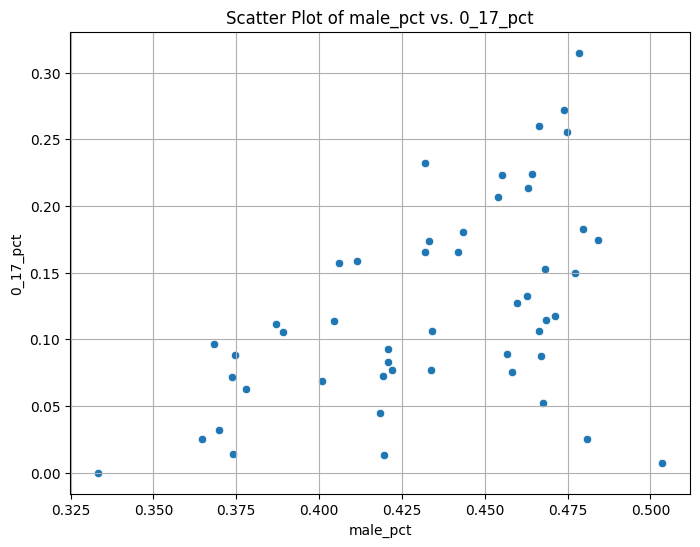

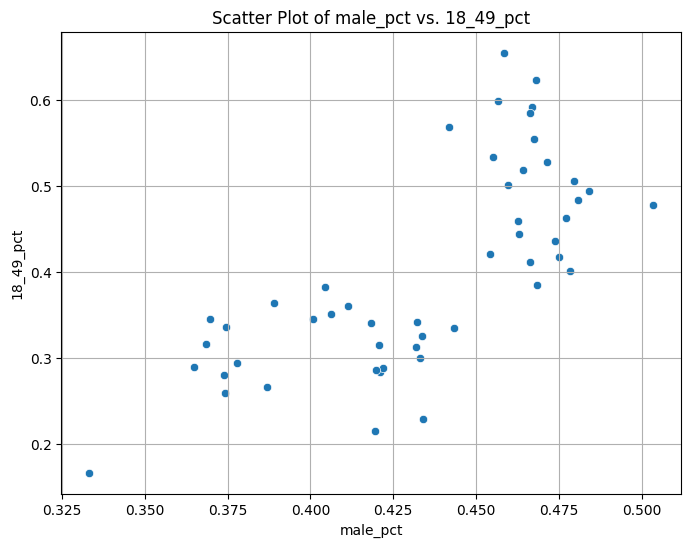

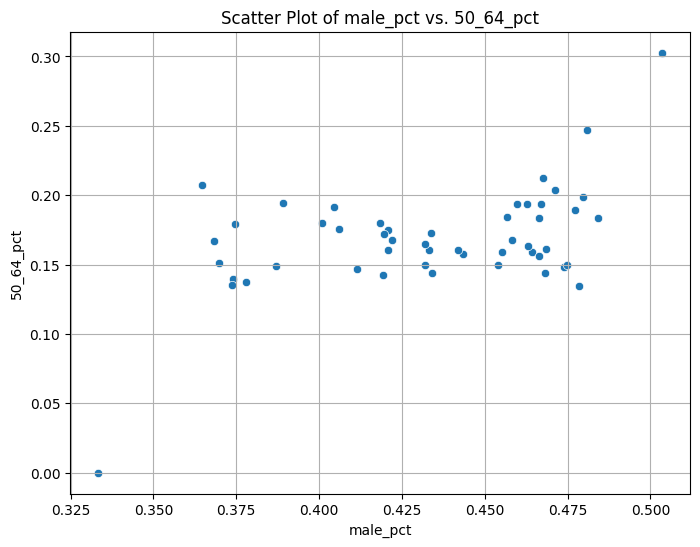

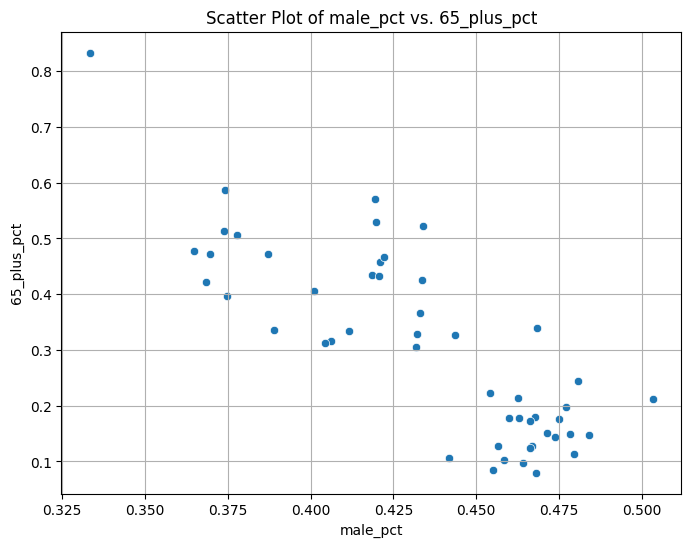

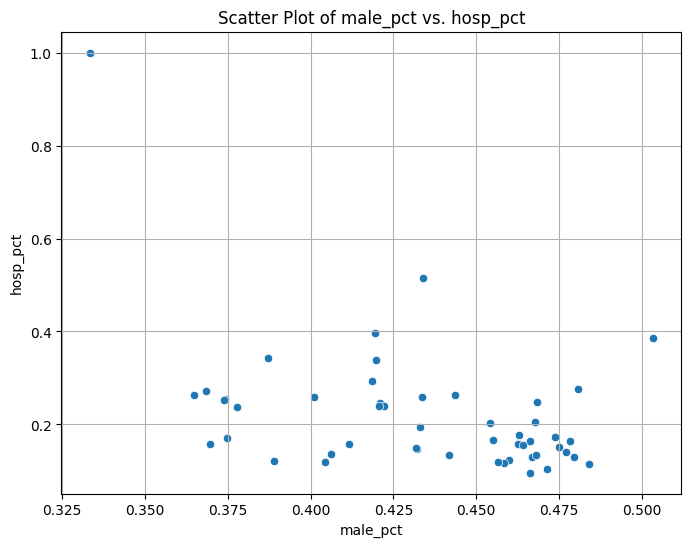

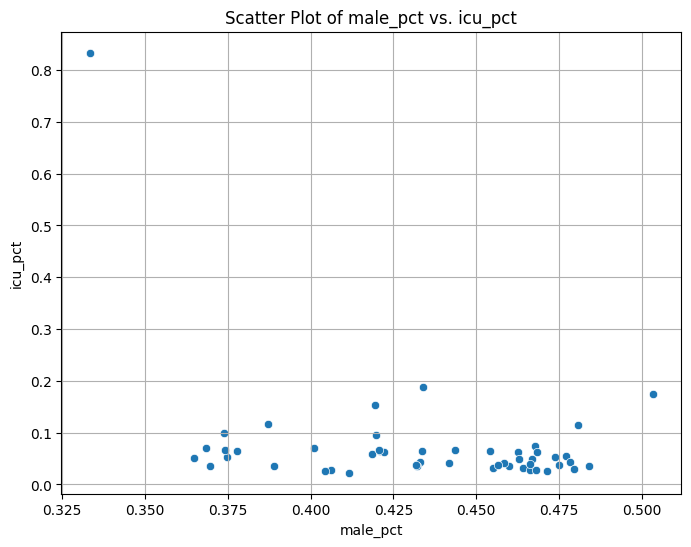

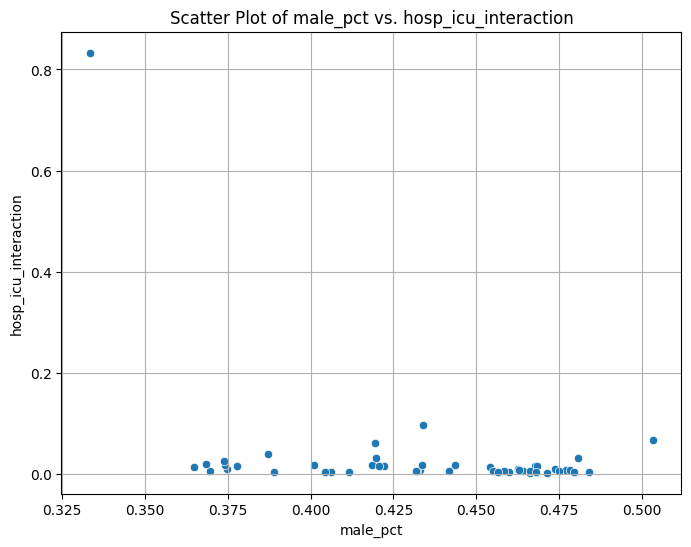

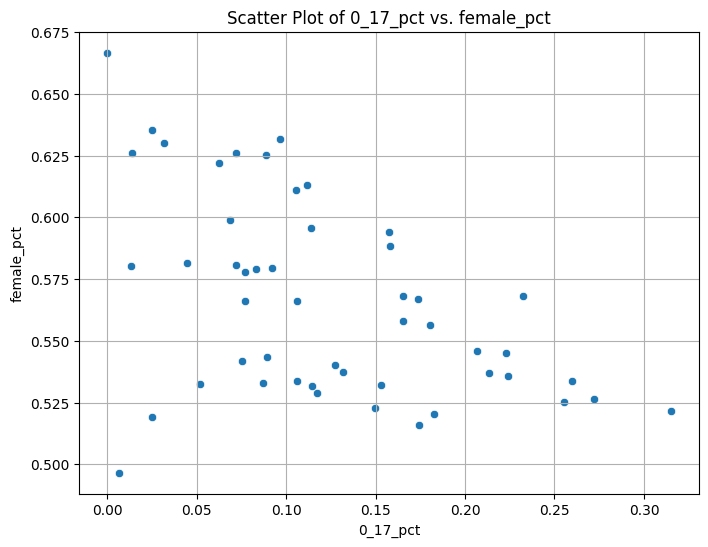

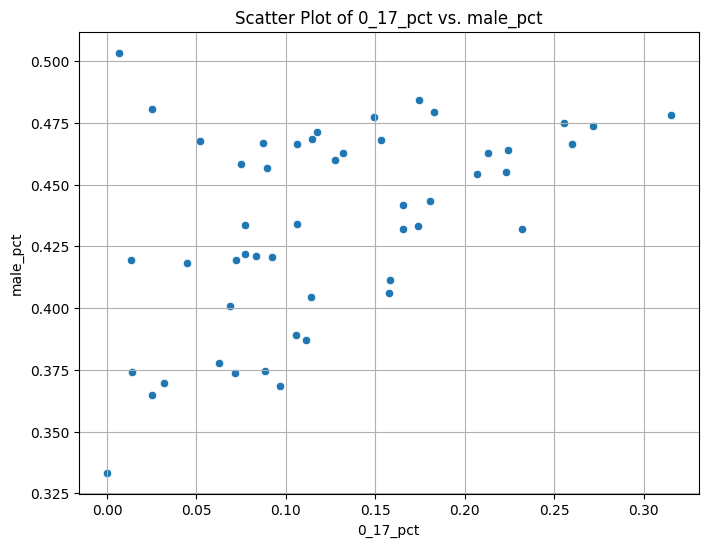

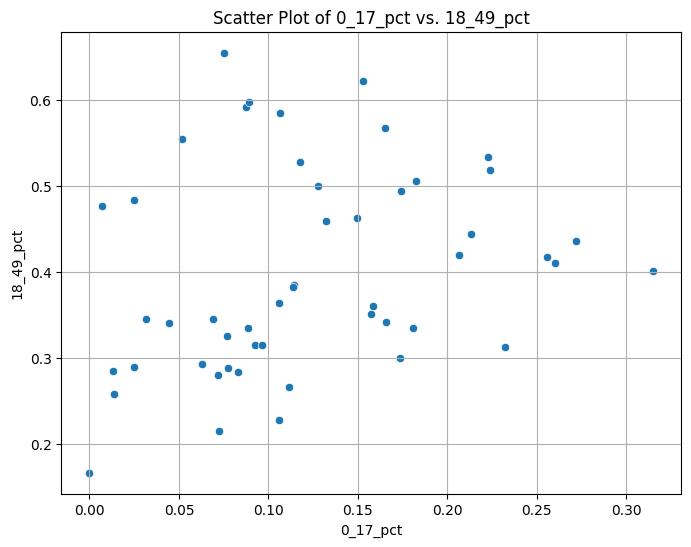

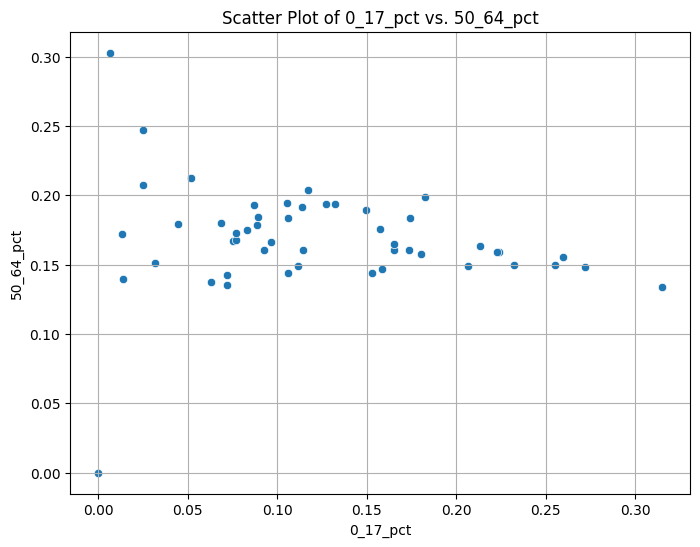

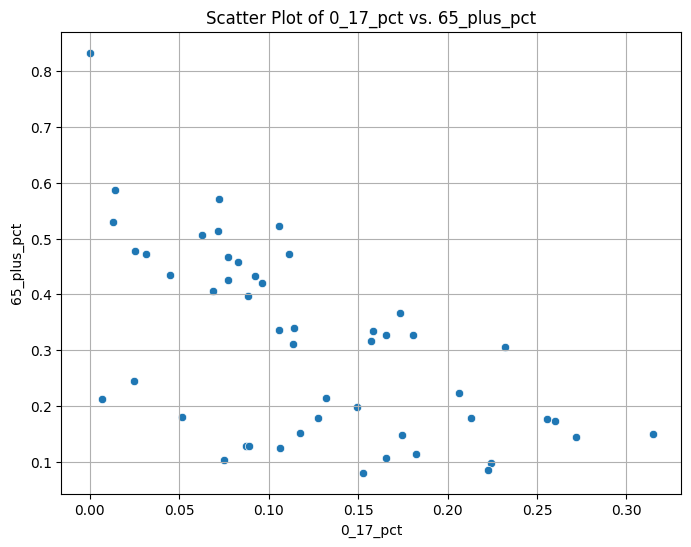

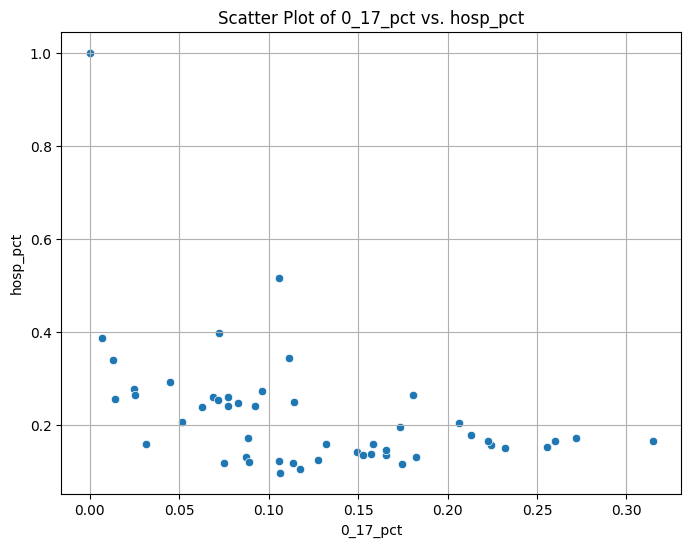

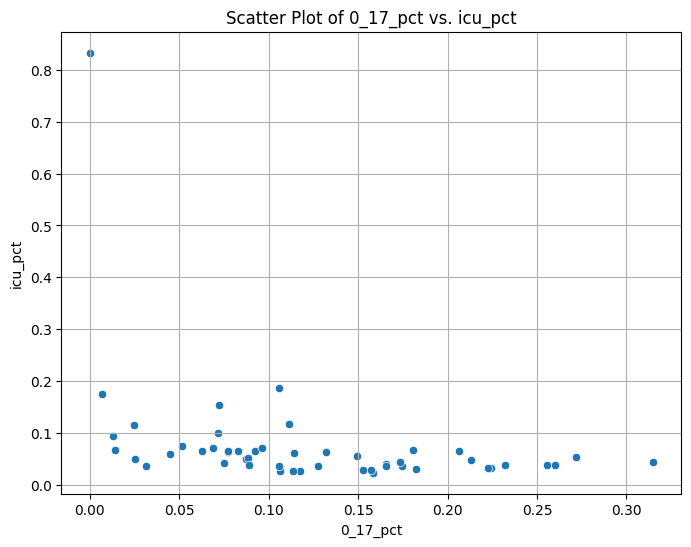

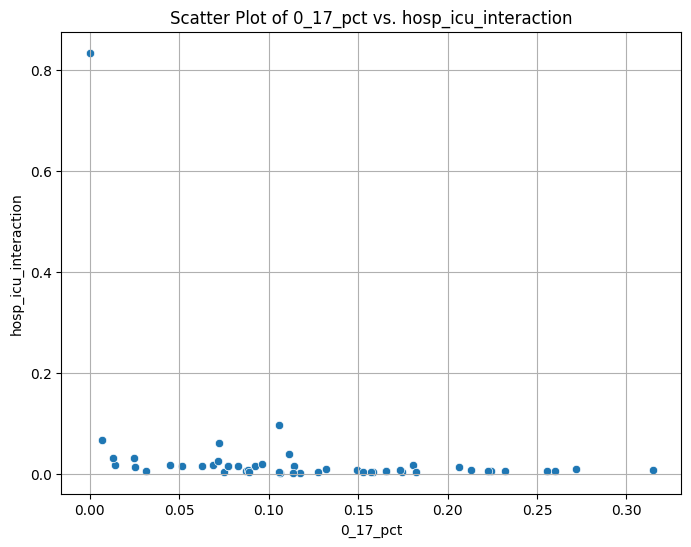

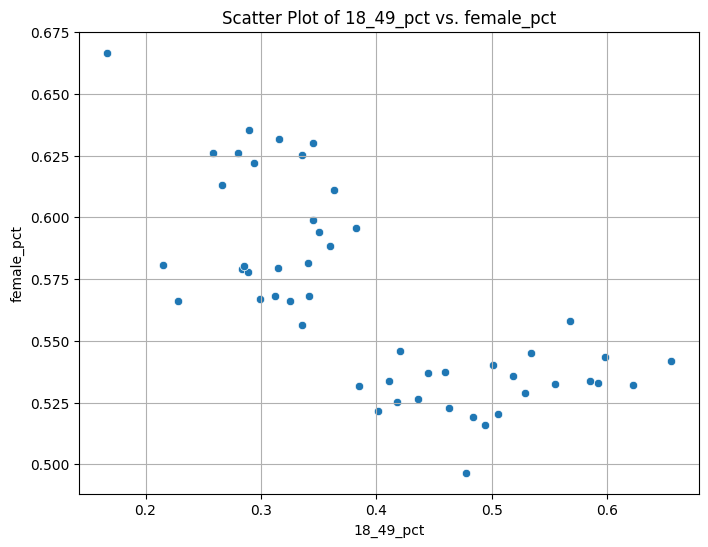

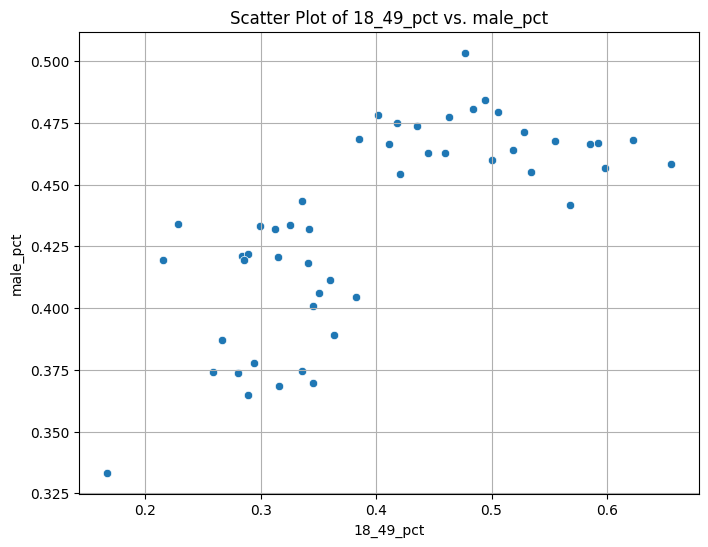

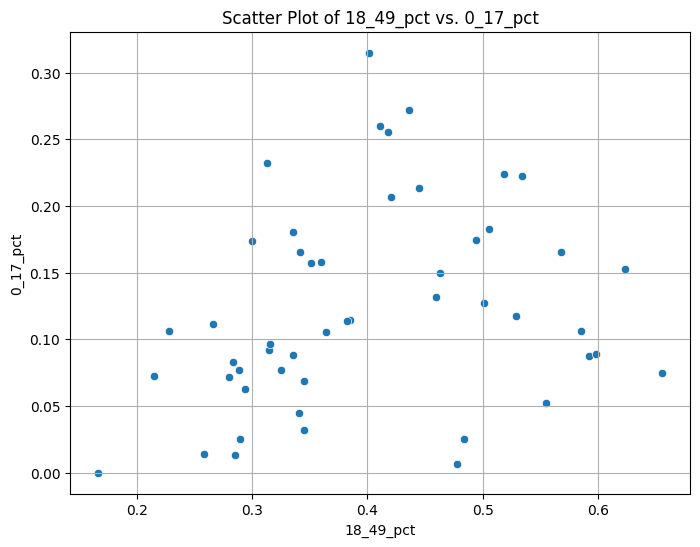

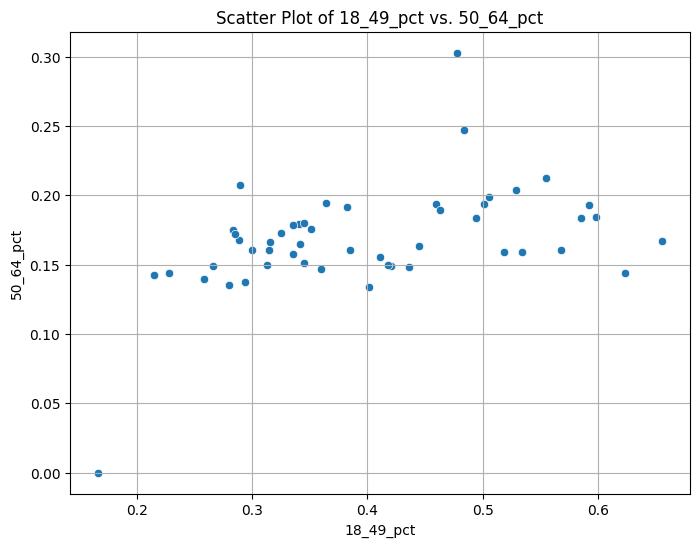

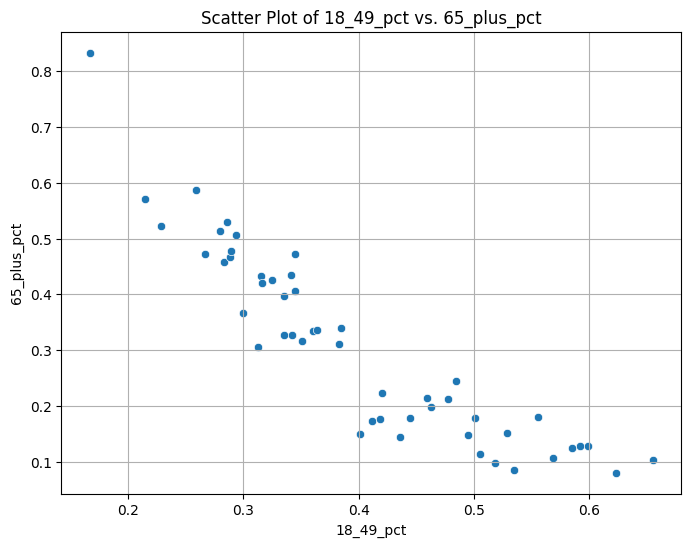

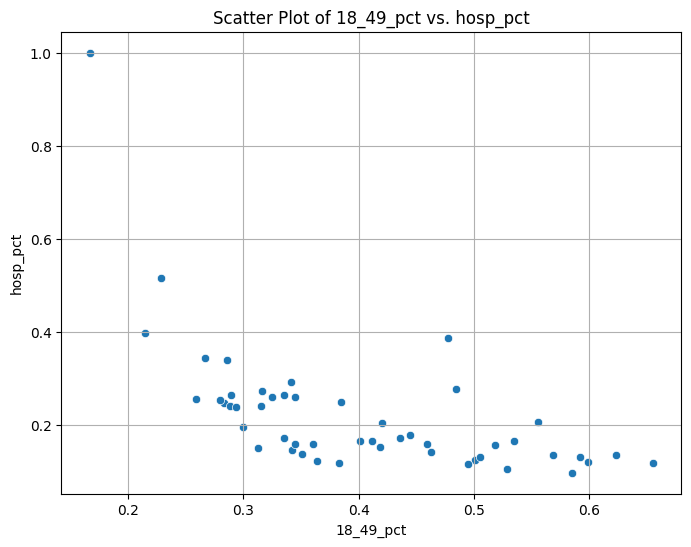

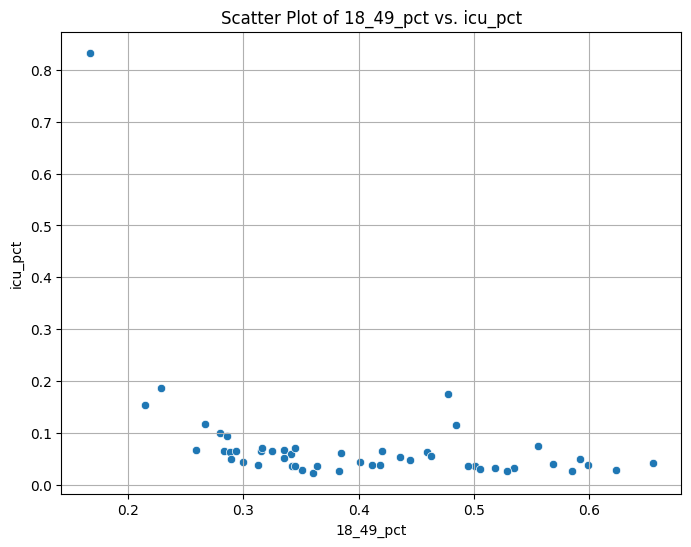

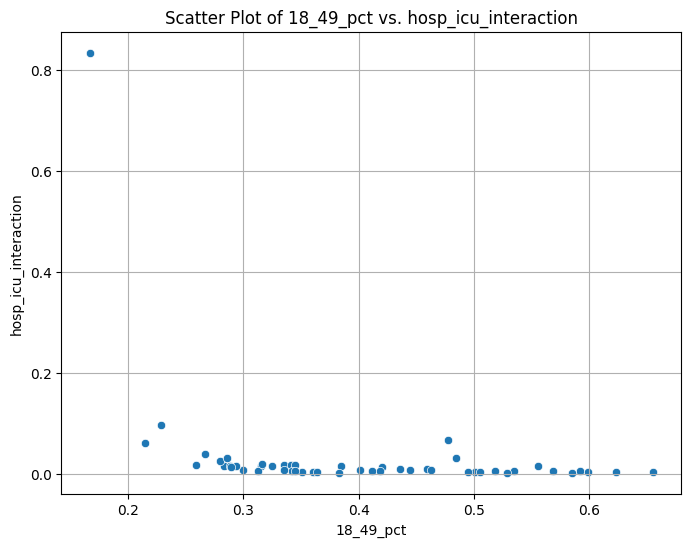

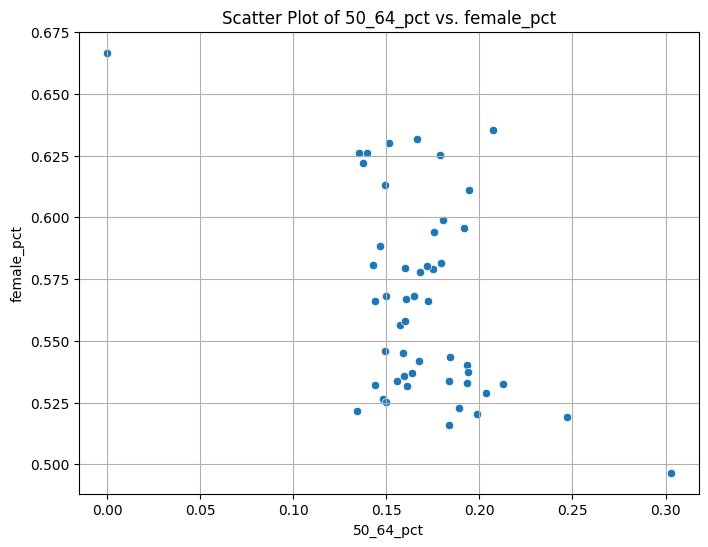

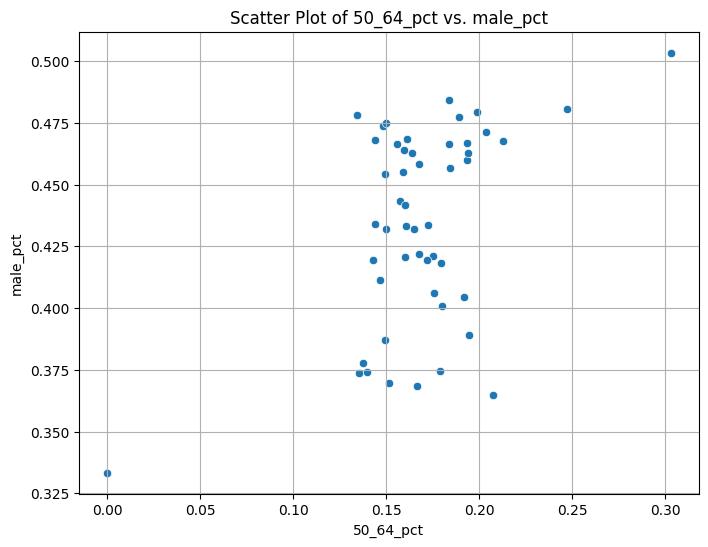

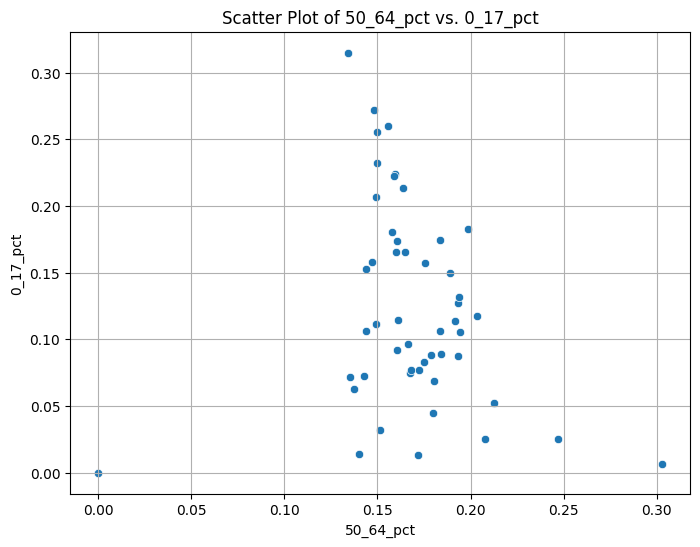

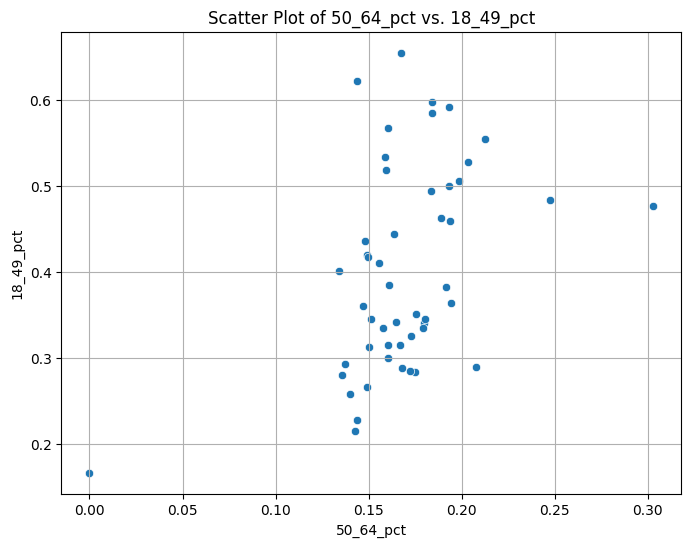

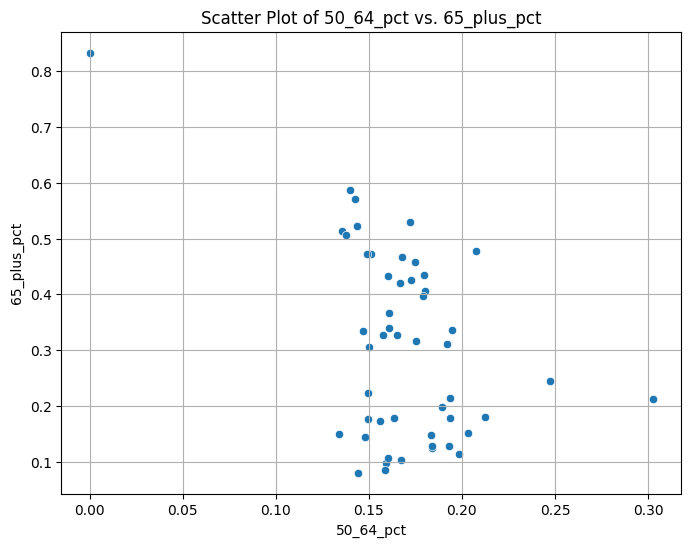

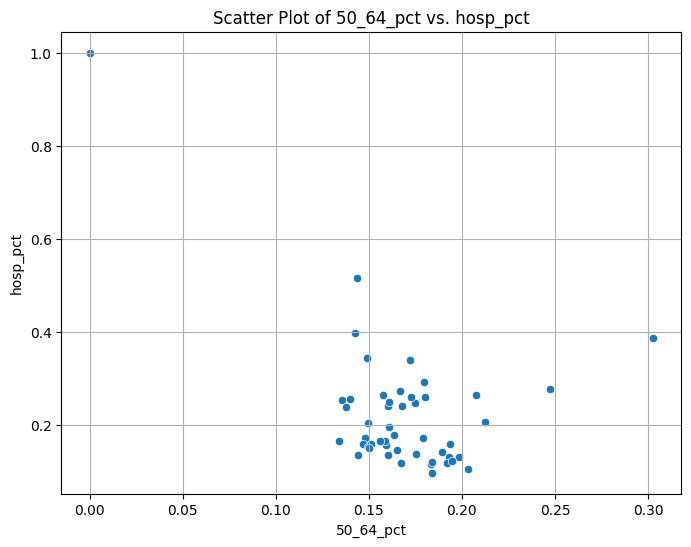

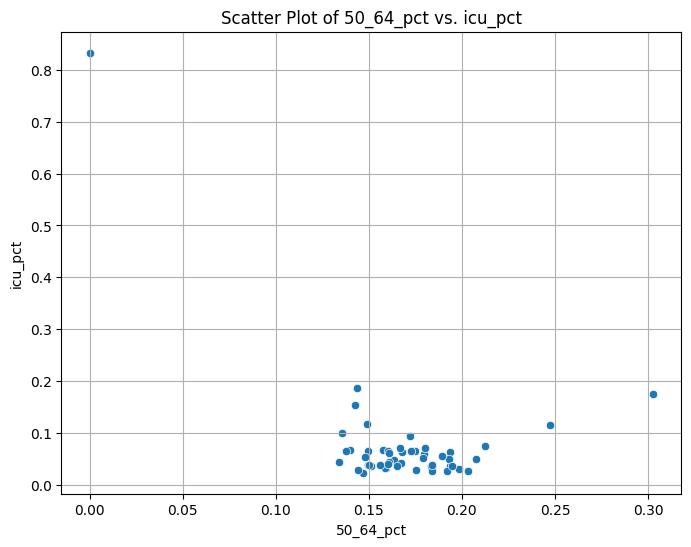

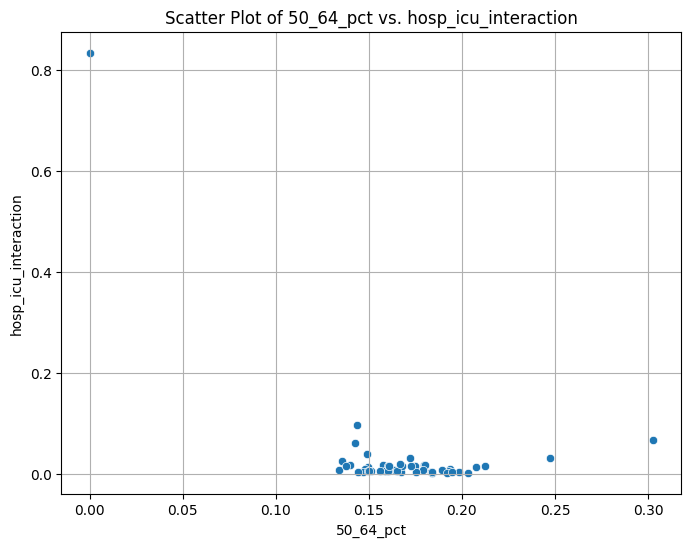

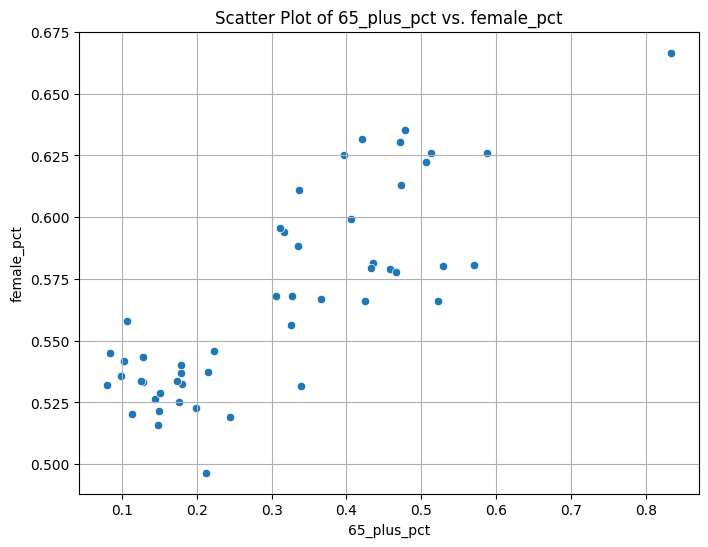

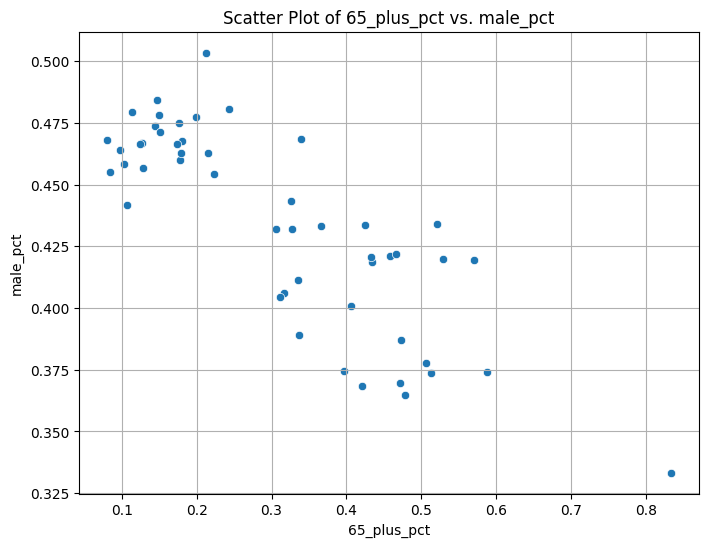

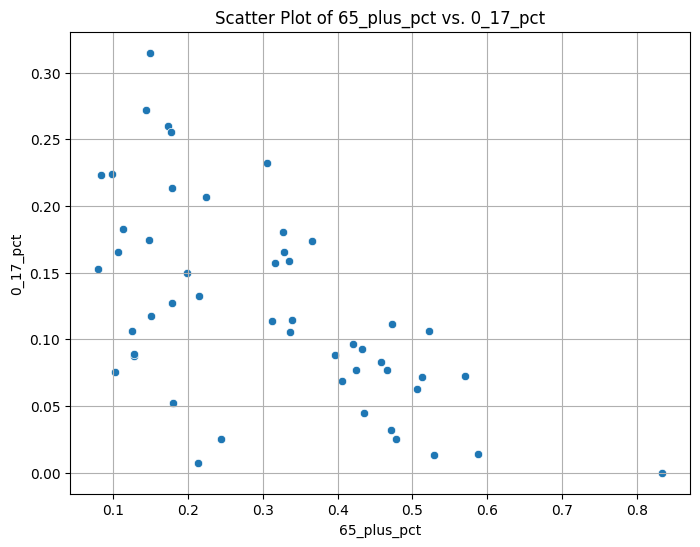

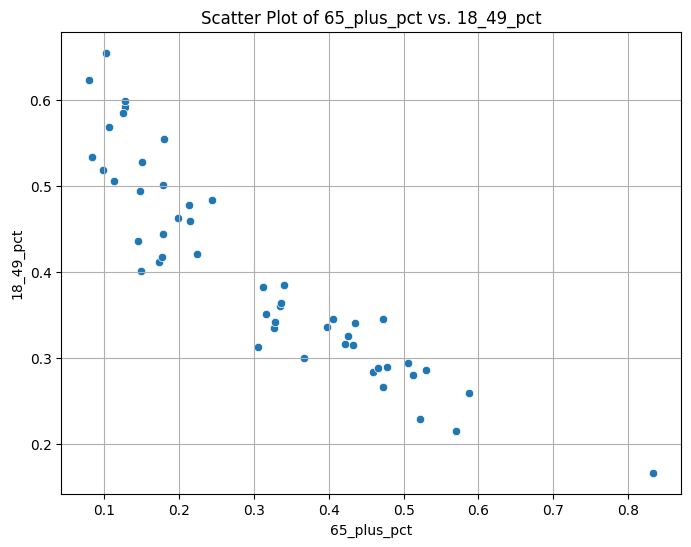

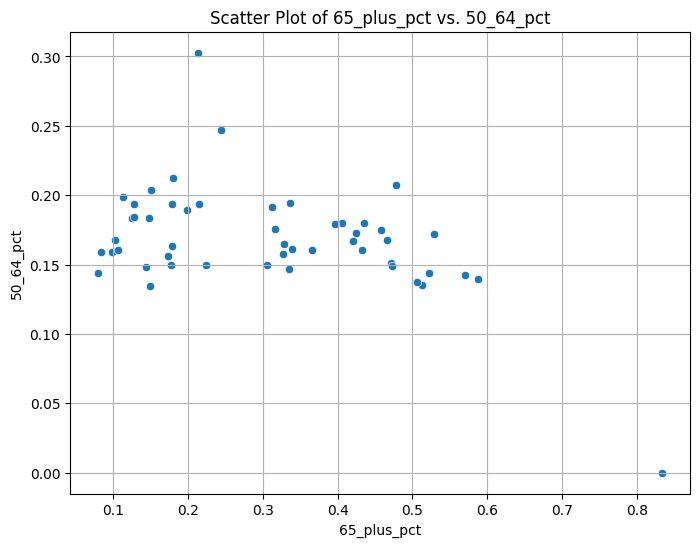

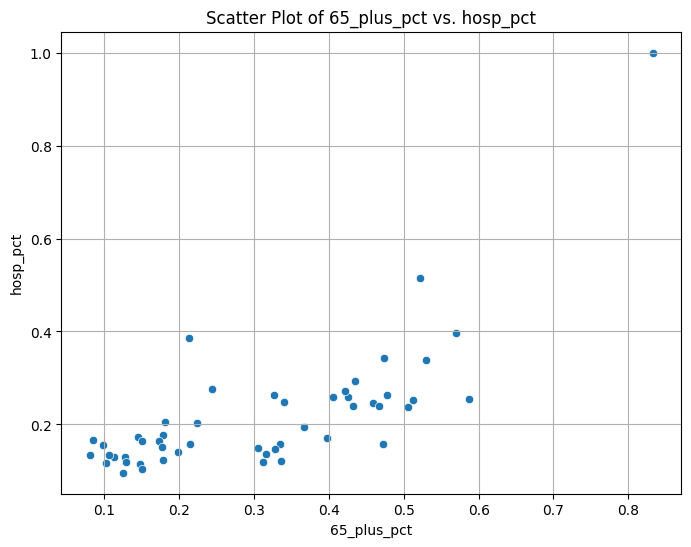

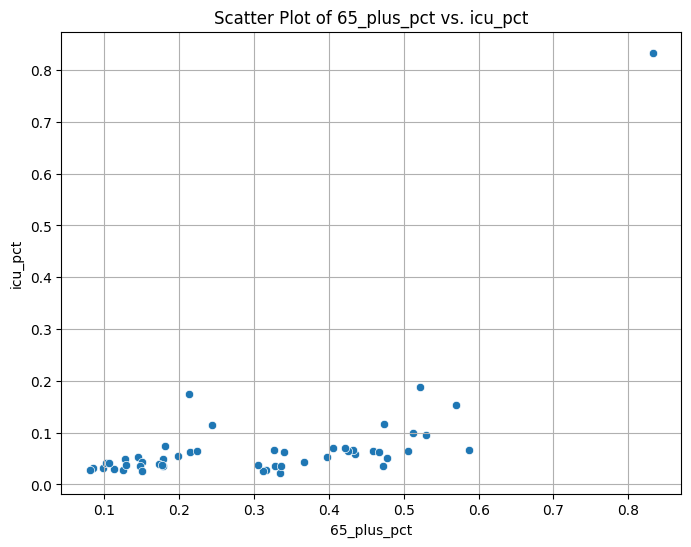

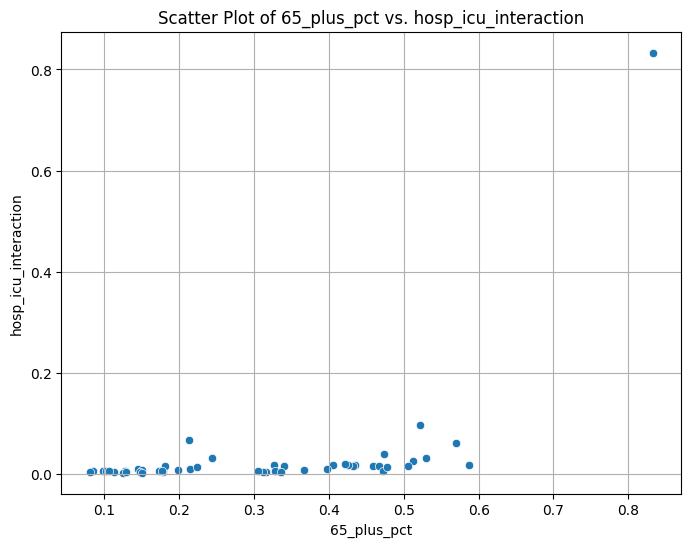

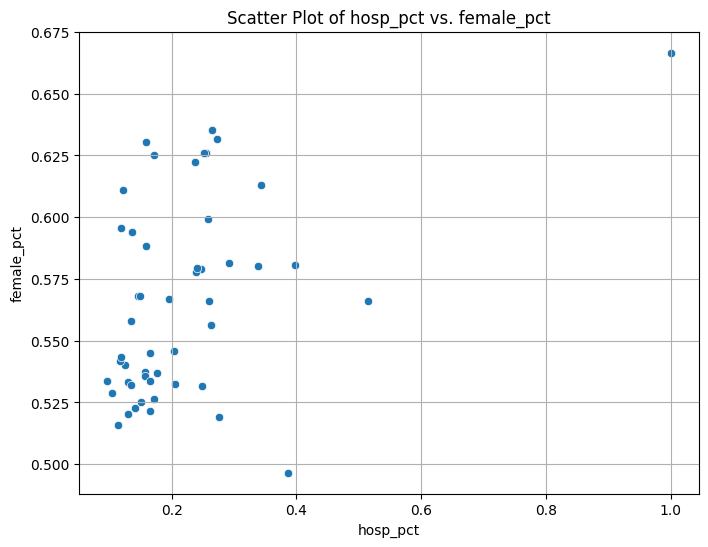

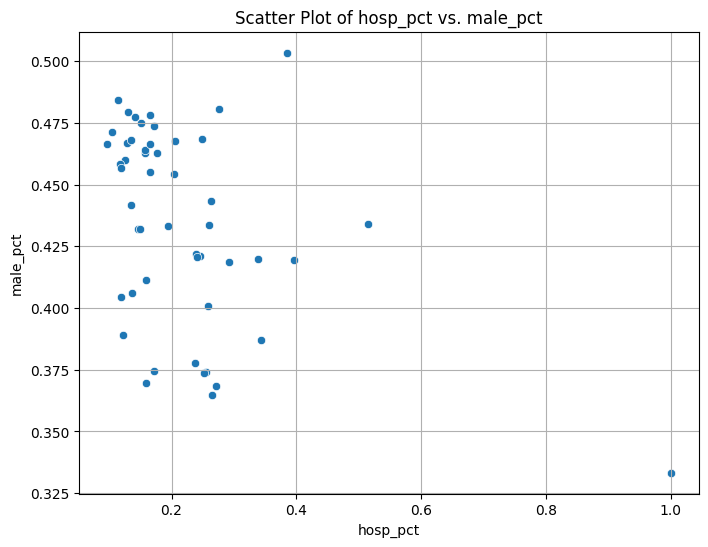

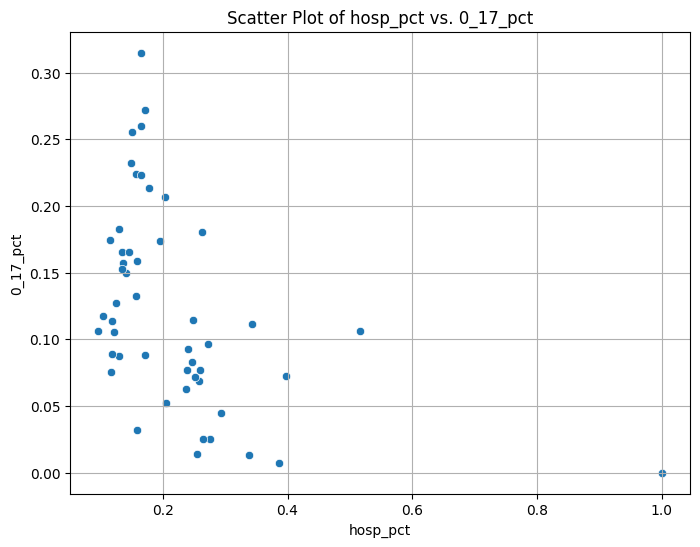

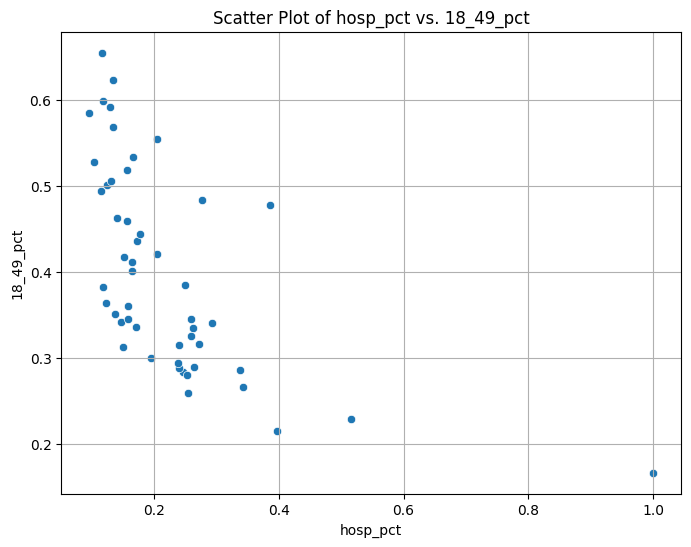

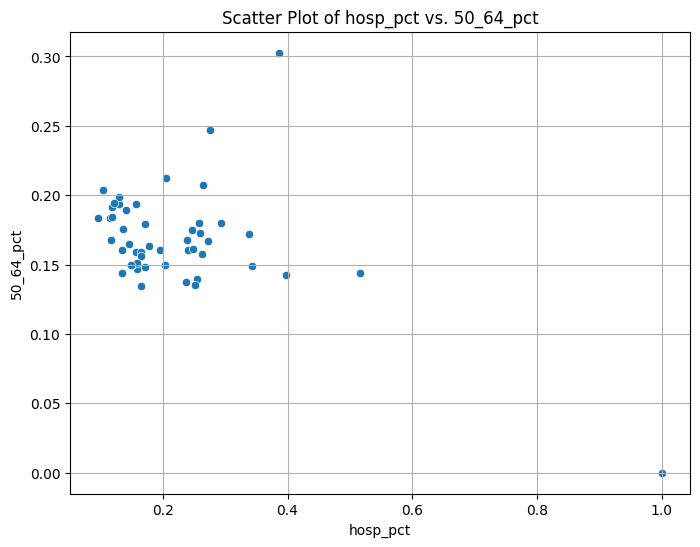

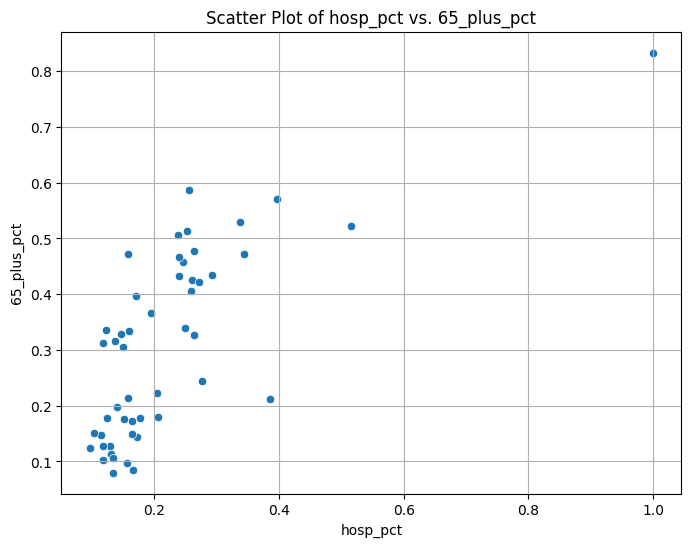

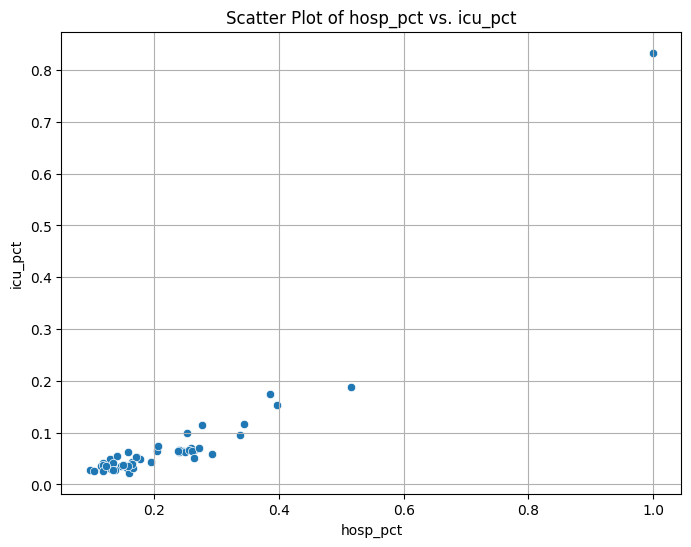

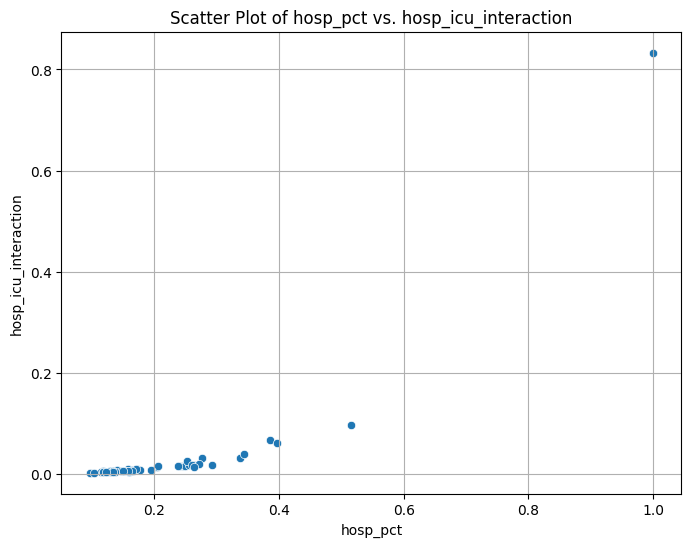

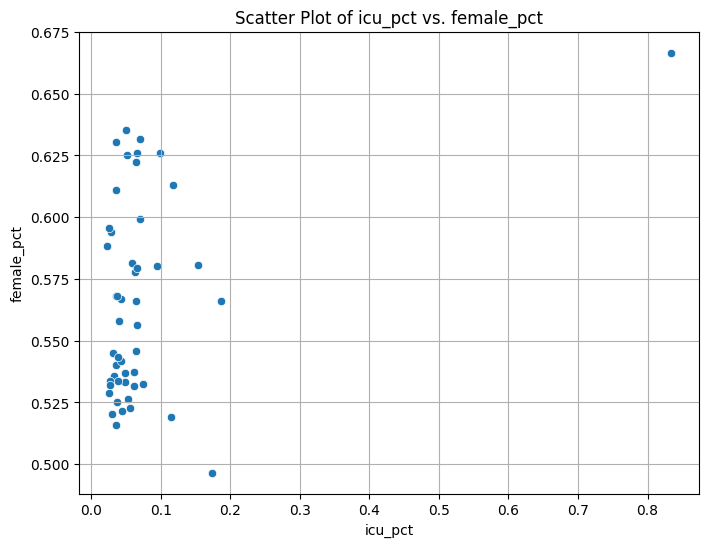

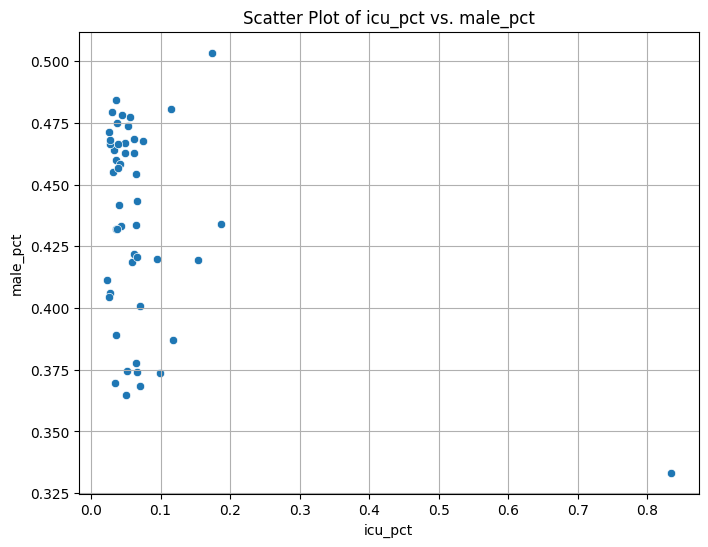

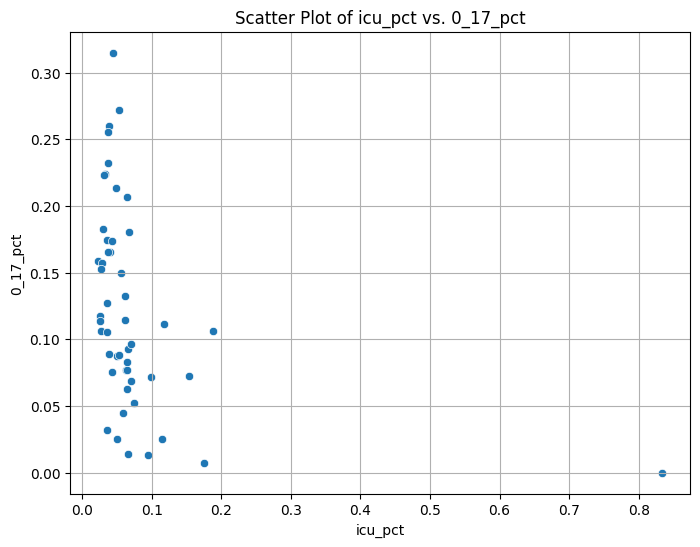

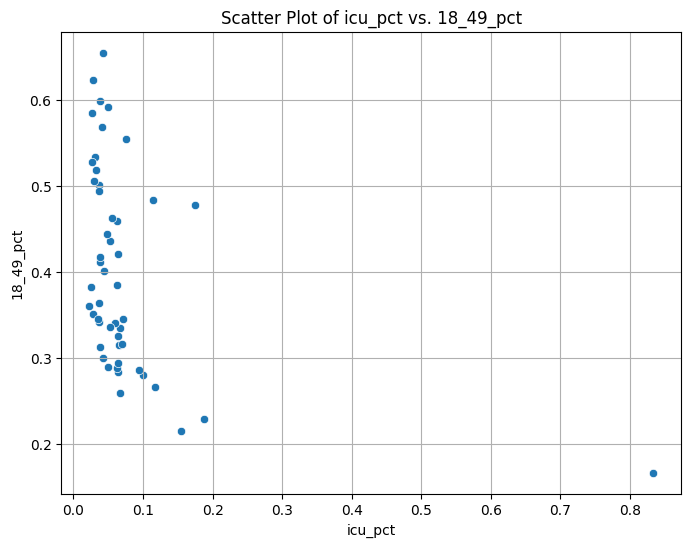

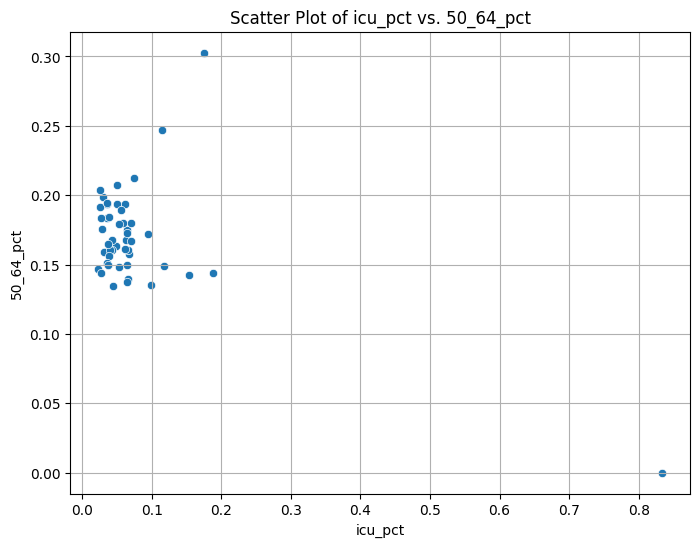

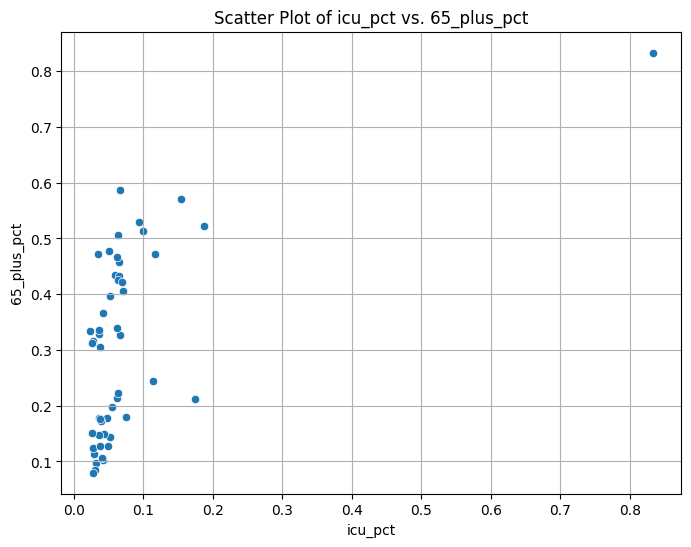

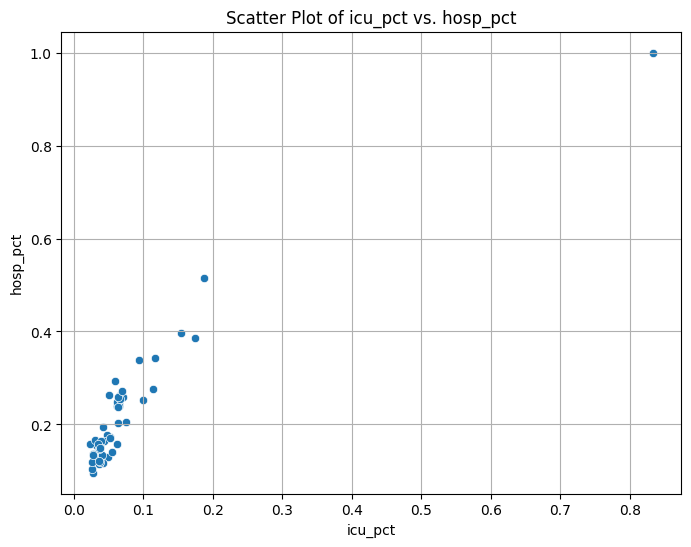

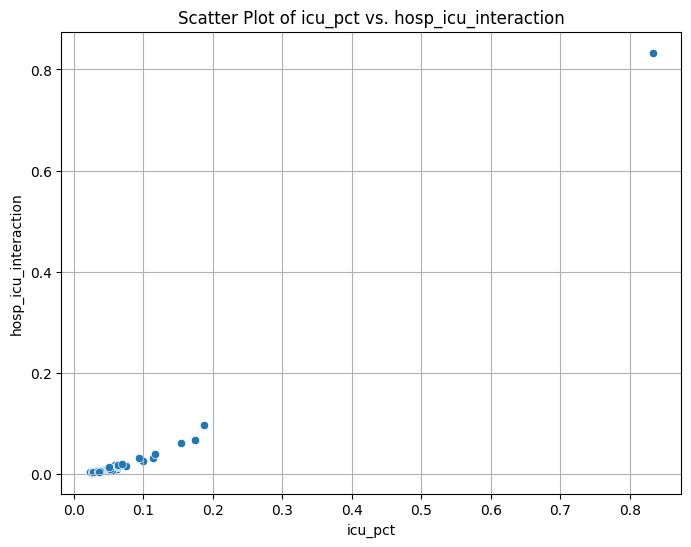

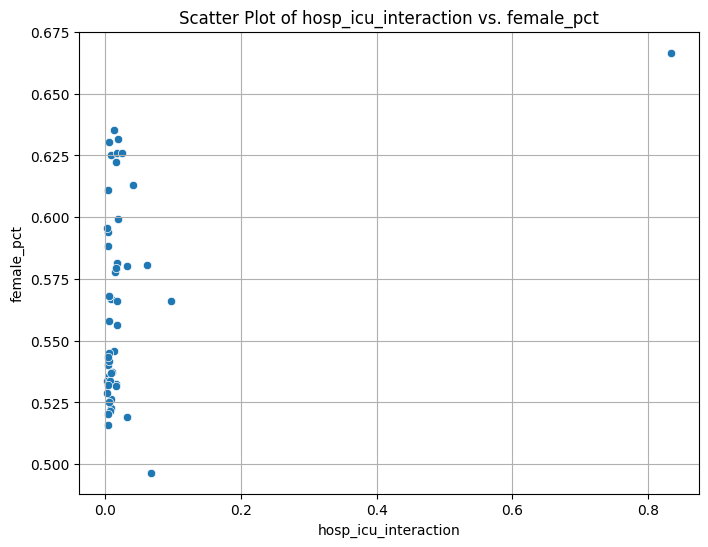

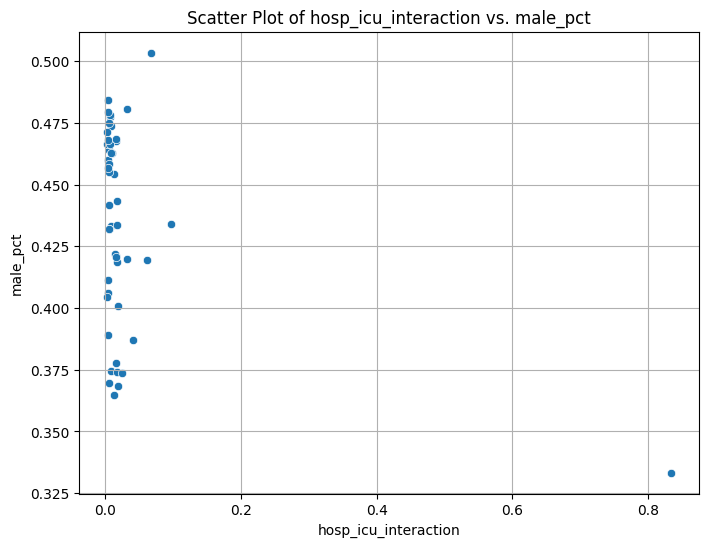

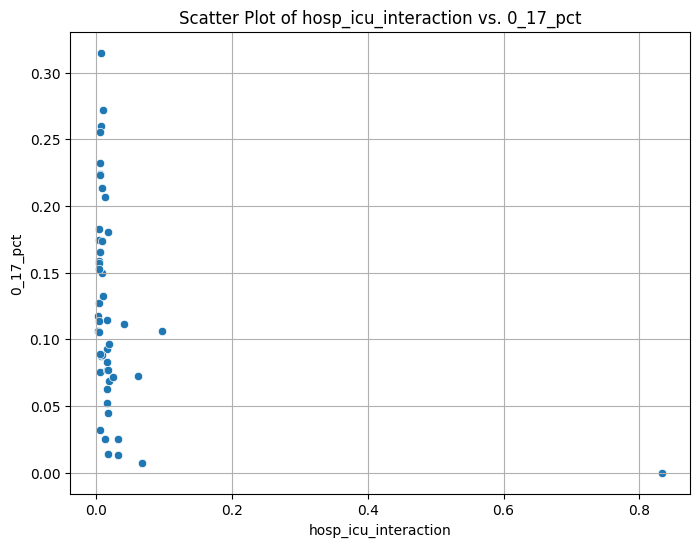

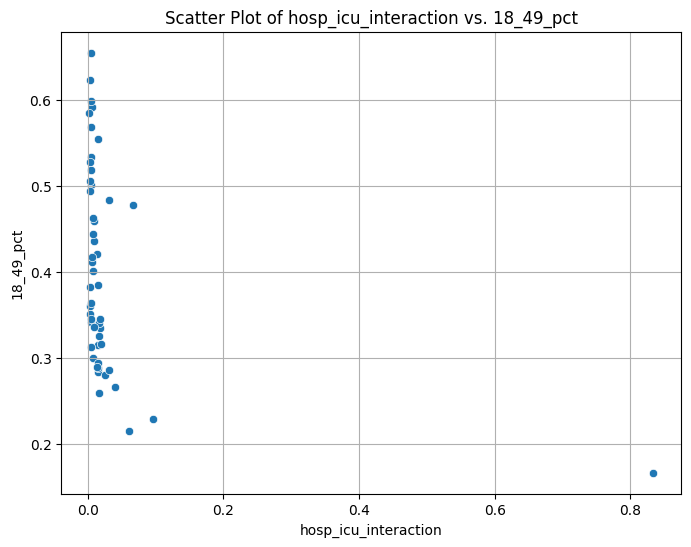

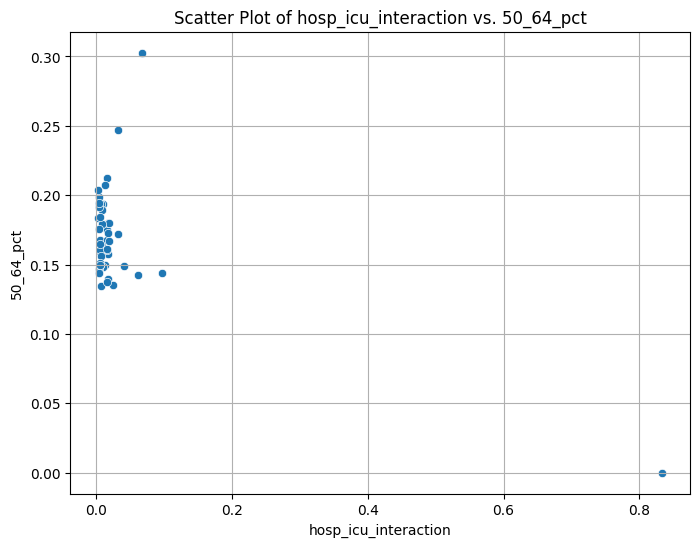

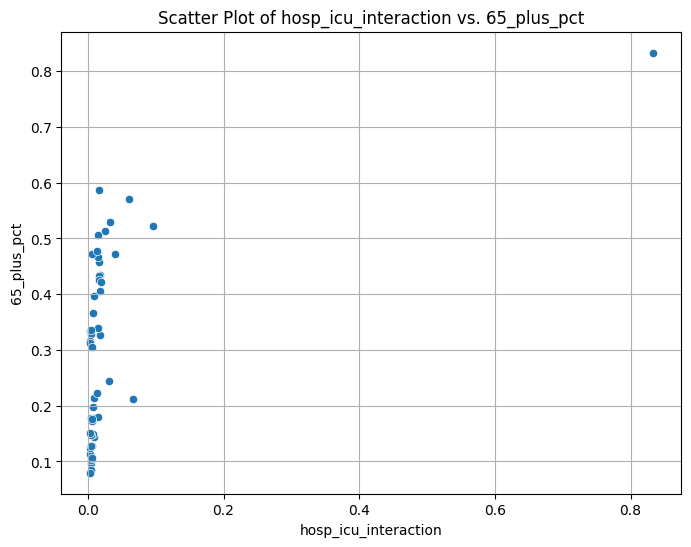

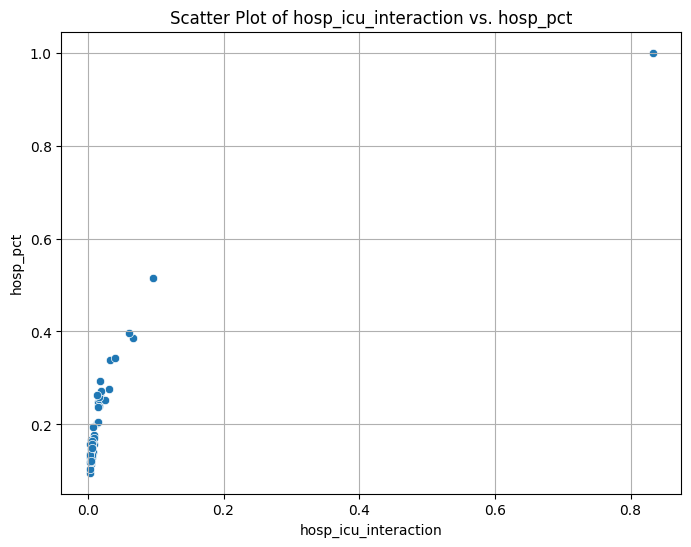

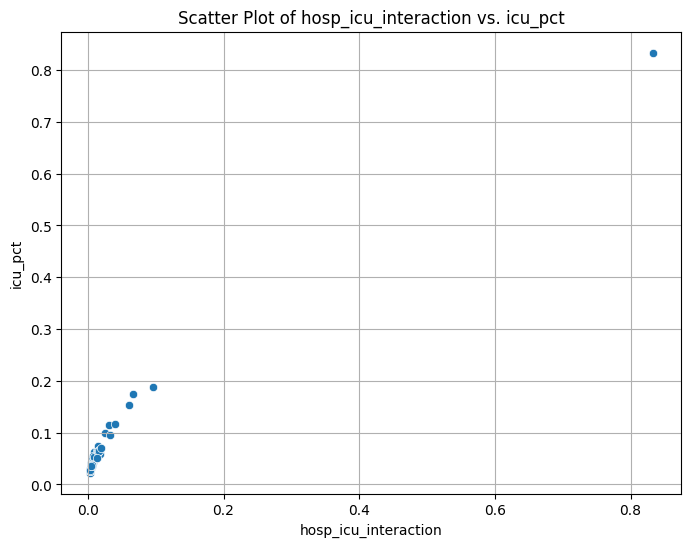

In [ ]:
# Scatter plots for each pair of features
for feature1 in X.columns:
    for feature2 in X.columns:
        if feature1 != feature2:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=monthly_data_df[feature1], y=monthly_data_df[feature2])
            plt.title(f'Scatter Plot of {feature1} vs. {feature2}')
            plt.xlabel(feature1)
            plt.ylabel(feature2)
            plt.grid(True)
            plt.show()

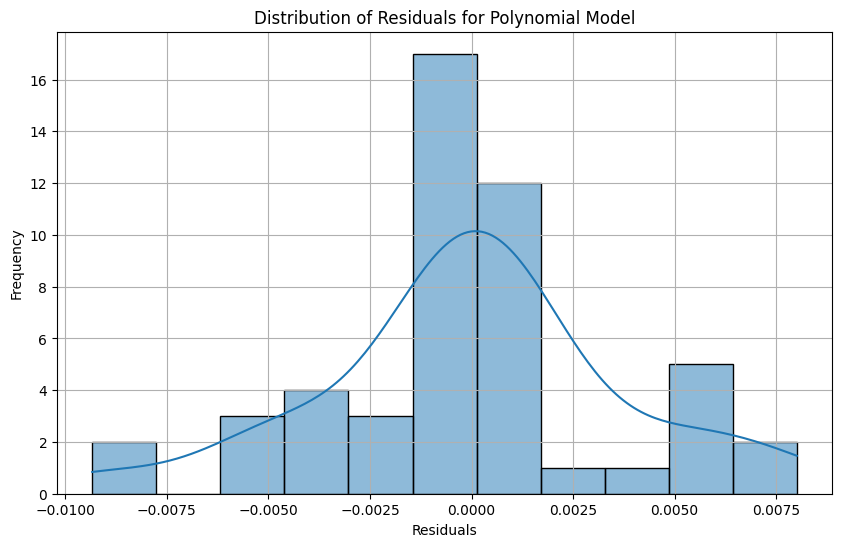

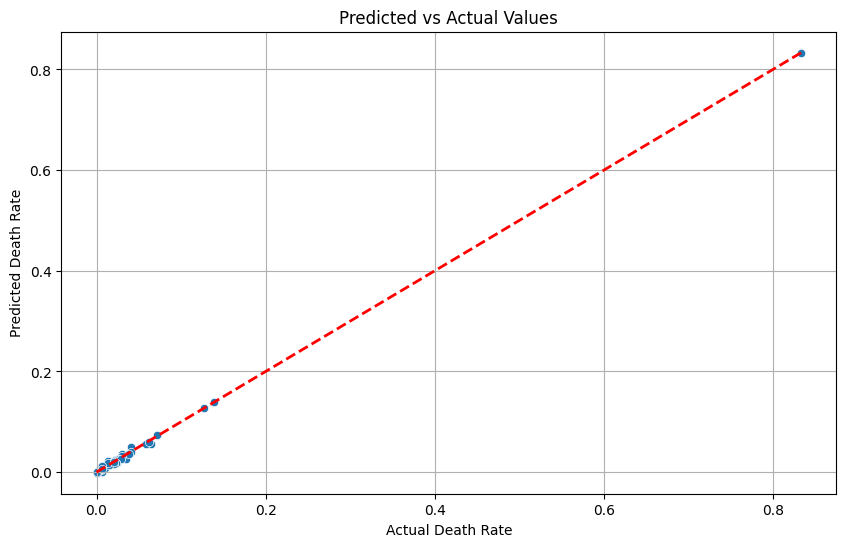

In [ ]:
# Predict using the polynomial model
y_pred_poly = model_poly_with_intercept.predict(X_poly_scaled_with_intercept)

# Calculate residuals
residuals_poly = y - y_pred_poly

# Plot the residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_poly, kde=True)
plt.title('Distribution of Residuals for Polynomial Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y, y=y_pred_poly)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Death Rate')
plt.ylabel('Predicted Death Rate')
plt.grid(True)
plt.show()

**PART 5: Bonus Task:**

 **Train a machine/deep learning classifier to predict the likelihood of death due to
COVID-19 using any/all of the relevant attributes in the COVID case surveillance
dataset.**